# MusicXML Tokenizer v3 — Efficiency & Vocabulary Optimization

**Goal:** Compact, well-distributed vocabulary without sacrificing round-trip accuracy. Analyze token distributions, quantize positions, merge rare pitches, and compute KL divergence.

**v3 improvements over v2:**
- Distributional analysis of full-corpus token frequencies with entropy measurement
- Position quantization: `POS_BAR` and `POS_ABS` rounded to 0.25 quarter-note grid
- Rare pitch merging: pitches with < 5 corpus occurrences mapped to nearest cent-grid neighbor
- Lyric vocabulary optimization: `LYRIC` tokens use a closed vocabulary with `LYRIC_<UNK>` fallback
- KL divergence between original and reconstructed token distributions

**All token types:** `<BOS>`, `<EOS>`, `PART_`, `TIME_SIG_`, `KEY_`, `CLEF_`, `BAR_`, `POS_BAR_`, `POS_ABS_`, `PITCH_`, `DUR_`, `REST`, `TIE_START`, `TIE_STOP`, `GRACE_`, `REPEAT_FWD`, `REPEAT_BWD`, `ENDING_`, `BARLINE_`, `FERMATA`, `TEMPO_`, `DYNAMICS_`, `LYRIC_`

---

## 1. Setup and Dependencies

In [29]:
# ── Install dependencies (for Google Colab) ──
# Uncomment the following lines if running on Colab:
# !pip install lxml music21 python-Levenshtein pandas matplotlib

import os
import glob
import random
import warnings
from pathlib import Path
from collections import Counter, defaultdict
from fractions import Fraction

from lxml import etree
import pandas as pd
import matplotlib.pyplot as plt

# Suppress music21 warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

# We import music21 for the detokenizer and evaluation only
import music21

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

print(f"lxml version: {etree.LXML_VERSION}")
print(f"music21 version: {music21.VERSION_STR}")
print("Setup complete.")

lxml version: (6, 0, 2, 0)
music21 version: 9.9.1
Setup complete.


## 2. Load Dataset File Paths

In [30]:
# ── Load all XML file paths from xml_v3/ ──
XML_DIR = Path("xml_v3")

# Also support Colab path structure
if not XML_DIR.exists():
    # Try relative to notebook location
    XML_DIR = Path("/content/musicxml_tokenizer/xml_v3")

all_xml_files = sorted(XML_DIR.glob("*.xml"))
print(f"Total XML files found: {len(all_xml_files)}")
print(f"\nFirst 5 files:")
for f in all_xml_files[:5]:
    print(f"  {f.name}")
print(f"\nLast 5 files:")
for f in all_xml_files[-5:]:
    print(f"  {f.name}")

# Select a random 100-file sample for evaluation
EVAL_SAMPLE_SIZE = 100
eval_sample = random.sample(all_xml_files, min(EVAL_SAMPLE_SIZE, len(all_xml_files)))
print(f"\nEvaluation sample size: {len(eval_sample)}")

Total XML files found: 3000

First 5 files:
  acem--ilahi--duyek--aldanma_dunya--zekai_dede.xml
  acem--ilahi--nimevsat--calabim_bir--haci_bayram_veli.xml
  acem--kupe--duyek--zulfunu--ahmet_avni_konuk.xml
  acem--selam--devrikebir--asik-i_ger--huseyin_fahreddin_dede.xml
  acem--seyir--sofyan----sefik_gurmeric.xml

Last 5 files:
  zavil--turku--sofyan--uc_gun--.xml
  zevk-itarab--kupe--musemmen--meclis-i--ahmet_avni_konuk.xml
  zevkidil--kupe--devrirevan--gel--ahmet_avni_konuk.xml
  zirefkend--kupe--aksaksemai--pertev-i--ahmet_avni_konuk.xml
  zirefkend--pesrev--darbifetih----gazi_giray_han.xml

Evaluation sample size: 100


## 2b. Build Microtonal Pitch Map from Full Corpus

Scan all 3,000 files to extract every unique `(step, alter)` pair, convert to a cent-grid at 0.01 resolution, and build a bidirectional mapping for lossless pitch tokenization.

In [31]:
# ── Scan corpus for all unique (step, alter) pairs ──
# This builds the microtonal pitch mapping used by the tokenizer.

from collections import defaultdict
import json

print("Scanning full corpus for microtonal pitch data...")
step_alter_pairs = set()
alter_values_by_step = defaultdict(set)
parse_errors = 0

for i, fp in enumerate(all_xml_files):
    if (i + 1) % 500 == 0:
        print(f"  Scanned {i + 1}/{len(all_xml_files)} files...")
    try:
        tree = etree.parse(str(fp))
        root = tree.getroot()
        for pitch_elem in root.iter("pitch"):
            step = pitch_elem.findtext("step", "C")
            alter_text = pitch_elem.findtext("alter")
            alter = float(alter_text) if alter_text else 0.0
            step_alter_pairs.add((step, alter))
            alter_values_by_step[step].add(alter)
    except Exception:
        parse_errors += 1

print(f"\nScan complete!")
print(f"  Parse errors: {parse_errors}")
print(f"  Unique (step, alter) pairs: {len(step_alter_pairs)}")
print(f"\nPer-step breakdown:")
for step in sorted(alter_values_by_step.keys()):
    alters = sorted(alter_values_by_step[step])
    print(f"  {step}: {len(alters)} alter values")
    # Show the alter values
    for a in alters:
        cents = round(a * 100, 2)
        print(f"      alter={a:+.8f}  →  {cents:+.2f} cents")

# ── Build cent-grid pitch map ──
# Convert each (step, alter) → a cent offset from the natural note
# Round to 0.01 cent resolution for the grid
# Token format: PITCH_<step>_<centOffset>_<octave>
#   e.g., PITCH_C_0.00_5  (natural C5)
#         PITCH_F_-7.55_5  (F5 lowered by 7.55 cents)

# Build forward map: (step, alter) → cent_label
# Build reverse map: cent_label → (step, alter)  for detokenization

pitch_map = {}        # (step, alter_rounded) → cent_label string
pitch_reverse = {}    # cent_label string → (step, alter_float)

for step, alter in sorted(step_alter_pairs):
    cents = round(alter * 100, 2)  # 0.01 cent resolution
    cent_label = f"{cents:+.2f}"   # e.g., "+0.00", "-7.55", "-92.45"
    key = (step, round(alter, 8))
    pitch_map[key] = f"{step}_{cent_label}"
    pitch_reverse[f"{step}_{cent_label}"] = (step, alter)

print(f"\nPitch map built: {len(pitch_map)} entries")
print(f"Reverse map built: {len(pitch_reverse)} entries")

# Show a few examples
print(f"\nExample mappings:")
for (step, alter), label in list(sorted(pitch_map.items()))[:10]:
    print(f"  ({step}, {alter:+.8f}) → {label}")

Scanning full corpus for microtonal pitch data...
  Scanned 500/3000 files...
  Scanned 1000/3000 files...
  Scanned 1500/3000 files...
  Scanned 2000/3000 files...
  Scanned 2500/3000 files...
  Scanned 3000/3000 files...

Scan complete!
  Parse errors: 70
  Unique (step, alter) pairs: 119

Per-step breakdown:
  A: 20 alter values
      alter=-1.35849056  →  -135.85 cents
      alter=-1.13207547  →  -113.21 cents
      alter=-1.07547170  →  -107.55 cents
      alter=-0.90566037  →  -90.57 cents
      alter=-0.84905660  →  -84.91 cents
      alter=-0.67924528  →  -67.92 cents
      alter=-0.62264151  →  -62.26 cents
      alter=-0.45283019  →  -45.28 cents
      alter=-0.39622642  →  -39.62 cents
      alter=-0.22641509  →  -22.64 cents
      alter=+0.00000000  →  +0.00 cents
      alter=+0.05660377  →  +5.66 cents
      alter=+0.22641510  →  +22.64 cents
      alter=+0.28301887  →  +28.30 cents
      alter=+0.45283019  →  +45.28 cents
      alter=+0.67924529  →  +67.92 cents
      alt

## 2c. Corpus Feature Scan (v2)

Scan all files for structural features new to v2: repeats, endings, fermatas, tempo markings, dynamics, lyrics, and barline styles.

In [32]:
# ── Corpus-wide scan for v2 structural features ──
print("Scanning corpus for v2 structural features...\n")

feature_counts = Counter()  # feature_name → number of files containing it
feature_values = defaultdict(Counter)  # feature_name → {value → count}
scan_errors = 0

for i, fp in enumerate(all_xml_files):
    if (i + 1) % 500 == 0:
        print(f"  Scanned {i + 1}/{len(all_xml_files)} files...")
    try:
        tree = etree.parse(str(fp))
        root = tree.getroot()

        # Repeats: <barline><repeat direction="forward|backward"/>
        repeats = root.findall(".//barline/repeat")
        if repeats:
            feature_counts['repeat'] += 1
            for r in repeats:
                direction = r.get("direction", "?")
                feature_values['repeat_direction'][direction] += 1

        # Endings: <barline><ending number="N" type="start|stop|discontinue">
        endings = root.findall(".//barline/ending")
        if endings:
            feature_counts['ending'] += 1
            for e in endings:
                etype = e.get("type", "?")
                enum = e.get("number", "?")
                feature_values['ending_type'][etype] += 1
                feature_values['ending_number'][enum] += 1

        # Barline styles: <barline><bar-style>
        barlines = root.findall(".//barline/bar-style")
        if barlines:
            feature_counts['barline_style'] += 1
            for b in barlines:
                if b.text:
                    feature_values['bar_style'][b.text] += 1

        # Fermata: <notations><fermata>
        fermatas = root.findall(".//notations/fermata")
        if fermatas:
            feature_counts['fermata'] += 1
            feature_values['fermata_count']['total'] += len(fermatas)

        # Tempo / Sound: <sound tempo="..."> or <direction><sound tempo="...">
        sounds = root.findall(".//sound[@tempo]")
        if sounds:
            feature_counts['tempo'] += 1
            for s in sounds:
                tempo = s.get("tempo", "?")
                feature_values['tempo_bpm'][tempo] += 1

        # Metronome: <direction><direction-type><metronome>
        metronomes = root.findall(".//metronome")
        if metronomes:
            feature_counts['metronome'] += 1

        # Dynamics: <direction><direction-type><dynamics>
        dynamics = root.findall(".//dynamics")
        if dynamics:
            feature_counts['dynamics'] += 1
            for d in dynamics:
                for child in d:
                    feature_values['dynamics_type'][child.tag] += 1

        # Lyrics: <note><lyric>
        lyrics = root.findall(".//lyric")
        if lyrics:
            feature_counts['lyrics'] += 1
            feature_values['lyrics_count']['total'] += len(lyrics)

        # Articulations: <notations><articulations>
        articulations = root.findall(".//notations/articulations")
        if articulations:
            feature_counts['articulations'] += 1
            for art in articulations:
                for child in art:
                    feature_values['articulation_type'][child.tag] += 1

        # Slurs: <notations><slur>
        slurs = root.findall(".//notations/slur")
        if slurs:
            feature_counts['slur'] += 1

    except Exception:
        scan_errors += 1

total_files = len(all_xml_files) - scan_errors
print(f"\nScan complete! ({scan_errors} parse errors)\n")
print(f"{'Feature':<20} {'Files':>8} {'% of corpus':>12}")
print(f"{'─' * 20} {'─' * 8} {'─' * 12}")
for feat in sorted(feature_counts.keys()):
    count = feature_counts[feat]
    pct = count / total_files * 100
    print(f"{feat:<20} {count:>8} {pct:>11.1f}%")

print(f"\n\nDetailed value distributions:")
for feat_name in sorted(feature_values.keys()):
    vals = feature_values[feat_name]
    print(f"\n  {feat_name}:")
    for val, cnt in vals.most_common(20):
        print(f"    {val}: {cnt}")

Scanning corpus for v2 structural features...

  Scanned 500/3000 files...
  Scanned 1000/3000 files...
  Scanned 1500/3000 files...
  Scanned 2000/3000 files...
  Scanned 2500/3000 files...
  Scanned 3000/3000 files...

Scan complete! (70 parse errors)

Feature                 Files  % of corpus
──────────────────── ──────── ────────────
articulations             492        16.8%
barline_style            1933        66.0%
dynamics                  272         9.3%
ending                   1325        45.2%
fermata                   189         6.5%
lyrics                   2483        84.7%
metronome                2930       100.0%
repeat                   1933        66.0%
slur                     2320        79.2%
tempo                    2930       100.0%


Detailed value distributions:

  articulation_type:
    staccato: 3816

  bar_style:
    heavy-light: 4918
    light-heavy: 4878

  dynamics_type:
    p: 2645
    f: 1176
    pp: 97

  ending_number:
    1: 5463
    2: 5459
   

## 2d. Distributional Analysis & Vocabulary Optimization (v3)

Full-corpus tokenization to analyze token frequency distributions, identify rare tokens, compute vocabulary entropy, and build optimized mappings for v3.

In [35]:
# ── Full-corpus tokenization for distributional analysis (v3) ──
import numpy as np
from math import log2

print("Tokenizing full corpus for distributional analysis...")
print("(Using v2 tokenizer — pre-optimization baseline)\n")

corpus_tokens = []        # flat list of all tokens across corpus
corpus_token_counts = Counter()  # token → frequency
file_token_lists = {}     # filepath → tokens (for per-file analysis)
tokenize_errors = 0

for i, fp in enumerate(all_xml_files):
    if (i + 1) % 500 == 0:
        print(f"  Tokenized {i + 1}/{len(all_xml_files)} files...")
    try:
        toks = tokenize(fp)
        corpus_tokens.extend(toks)
        for t in toks:
            corpus_token_counts[t] += 1
        file_token_lists[str(fp)] = toks
    except Exception:
        tokenize_errors += 1

total_tokens = len(corpus_tokens)
v2_vocab = set(corpus_token_counts.keys())
v2_vocab_size = len(v2_vocab)

print(f"\n{'═' * 60}")
print(f"FULL-CORPUS v2 BASELINE STATISTICS")
print(f"{'═' * 60}")
print(f"Files tokenized:   {len(file_token_lists):,}")
print(f"Tokenization errors: {tokenize_errors}")
print(f"Total tokens:      {total_tokens:,}")
print(f"Vocabulary size:   {v2_vocab_size:,}")
print(f"Mean tokens/file:  {total_tokens / max(1, len(file_token_lists)):.0f}")

# ── Vocabulary entropy ──
probs = np.array([corpus_token_counts[t] for t in v2_vocab], dtype=float)
probs = probs / probs.sum()
v2_entropy = -np.sum(probs * np.log2(probs + 1e-15))
max_entropy = log2(v2_vocab_size)
print(f"\nVocabulary entropy: {v2_entropy:.2f} bits")
print(f"Max entropy (uniform): {max_entropy:.2f} bits")
print(f"Efficiency (H/H_max): {v2_entropy / max_entropy:.3f}")

# ── Token category breakdown ──
print(f"\n{'─' * 50}")
print(f"TOKEN CATEGORY BREAKDOWN")
print(f"{'─' * 50}")
category_counts = Counter()
category_vocab = defaultdict(set)
for token, count in corpus_token_counts.items():
    if token in ('<BOS>', '<EOS>'):
        cat = 'BOUNDARY'
    elif '_' in token:
        cat = token.split('_')[0]
    else:
        cat = token
    category_counts[cat] += count
    category_vocab[cat].add(token)

print(f"{'Category':<14} {'Tokens':>10} {'Vocab':>8} {'% of total':>12}")
print(f"{'─' * 14} {'─' * 10} {'─' * 8} {'─' * 12}")
for cat, cnt in category_counts.most_common():
    v_size = len(category_vocab[cat])
    pct = cnt / total_tokens * 100
    print(f"{cat:<14} {cnt:>10,} {v_size:>8} {pct:>11.1f}%")

# ── Rare token analysis ──
print(f"\n{'─' * 50}")
print(f"RARE TOKEN ANALYSIS (< 5 occurrences)")
print(f"{'─' * 50}")
rare_tokens = {t: c for t, c in corpus_token_counts.items() if c < 5}
rare_by_category = defaultdict(list)
for t, c in rare_tokens.items():
    if '_' in t:
        cat = t.split('_')[0]
    else:
        cat = t
    rare_by_category[cat].append((t, c))

print(f"Total rare tokens: {len(rare_tokens)} / {v2_vocab_size} ({len(rare_tokens)/v2_vocab_size*100:.1f}% of vocab)")
print(f"\nBy category:")
for cat in sorted(rare_by_category.keys()):
    items = rare_by_category[cat]
    print(f"  {cat}: {len(items)} rare tokens")
    for t, c in sorted(items, key=lambda x: x[1])[:5]:
        print(f"    {t}: {c}")
    if len(items) > 5:
        print(f"    ... and {len(items) - 5} more")

# ── High-frequency token analysis ──
print(f"\n{'─' * 50}")
print(f"TOP 30 MOST FREQUENT TOKENS")
print(f"{'─' * 50}")
for t, c in corpus_token_counts.most_common(30):
    pct = c / total_tokens * 100
    print(f"  {t:<35} {c:>10,}  ({pct:.2f}%)")

# ── Position token analysis ──
pos_bar_tokens = {t: c for t, c in corpus_token_counts.items() if t.startswith("POS_BAR_")}
pos_abs_tokens = {t: c for t, c in corpus_token_counts.items() if t.startswith("POS_ABS_")}
print(f"\n{'─' * 50}")
print(f"POSITION TOKEN ANALYSIS")
print(f"{'─' * 50}")
print(f"POS_BAR unique values: {len(pos_bar_tokens)}")
print(f"POS_ABS unique values: {len(pos_abs_tokens)}")
print(f"\nPOS_BAR top 20:")
for t, c in sorted(pos_bar_tokens.items(), key=lambda x: -x[1])[:20]:
    print(f"  {t}: {c:,}")
print(f"\nPOS_BAR rare (< 5 occ):")
pos_bar_rare = [(t, c) for t, c in pos_bar_tokens.items() if c < 5]
print(f"  {len(pos_bar_rare)} / {len(pos_bar_tokens)} are rare")

# ── Pitch token distribution ──
pitch_tokens = {t: c for t, c in corpus_token_counts.items() if t.startswith("PITCH_")}
print(f"\n{'─' * 50}")
print(f"PITCH TOKEN ANALYSIS")
print(f"{'─' * 50}")
print(f"Unique pitch tokens: {len(pitch_tokens)}")
pitch_rare = [(t, c) for t, c in pitch_tokens.items() if c < 5]
print(f"Rare pitch tokens (< 5 occ): {len(pitch_rare)}")
for t, c in sorted(pitch_rare, key=lambda x: x[1]):
    print(f"  {t}: {c}")

# ── Lyric token analysis ──
lyric_tokens = {t: c for t, c in corpus_token_counts.items() if t.startswith("LYRIC_")}
print(f"\n{'─' * 50}")
print(f"LYRIC TOKEN ANALYSIS")
print(f"{'─' * 50}")
print(f"Unique lyric tokens: {len(lyric_tokens)}")
lyric_rare = [(t, c) for t, c in lyric_tokens.items() if c < 5]
print(f"Lyric tokens appearing < 5 times: {len(lyric_rare)} ({len(lyric_rare)/max(1,len(lyric_tokens))*100:.1f}%)")
lyric_common = [(t, c) for t, c in sorted(lyric_tokens.items(), key=lambda x: -x[1])[:20]]
print(f"\nTop 20 lyric tokens:")
for t, c in lyric_common:
    print(f"  {t}: {c:,}")

# ── Duration token analysis ──
dur_tokens = {t: c for t, c in corpus_token_counts.items() if t.startswith("DUR_")}
print(f"\n{'─' * 50}")
print(f"DURATION TOKEN ANALYSIS")
print(f"{'─' * 50}")
print(f"Unique duration tokens: {len(dur_tokens)}")
for t, c in sorted(dur_tokens.items(), key=lambda x: -x[1]):
    print(f"  {t}: {c:,}")

Tokenizing full corpus for distributional analysis...
(Using v2 tokenizer — pre-optimization baseline)

  Tokenized 500/3000 files...
  Tokenized 1000/3000 files...
  Tokenized 1500/3000 files...
  Tokenized 2000/3000 files...
  Tokenized 2500/3000 files...
  Tokenized 3000/3000 files...

════════════════════════════════════════════════════════════
FULL-CORPUS v2 BASELINE STATISTICS
════════════════════════════════════════════════════════════
Files tokenized:   2,930
Tokenization errors: 70
Total tokens:      3,487,933
Vocabulary size:   20,758
Mean tokens/file:  1190

Vocabulary entropy: 8.00 bits
Max entropy (uniform): 14.34 bits
Efficiency (H/H_max): 0.558

──────────────────────────────────────────────────
TOKEN CATEGORY BREAKDOWN
──────────────────────────────────────────────────
Category           Tokens    Vocab   % of total
────────────── ────────── ──────── ────────────
POS             1,489,648    15581        42.7%
DUR               744,824       24        21.4%
PITCH       

In [36]:
# ── Build v3 optimization mappings ──
# Based on distributional analysis, define the three optimizations:
#   1. Position quantization: POS_BAR/POS_ABS → 0.25 quarter-note grid
#   2. Rare pitch merging: map rare pitch tokens to nearest neighbor
#   3. Lyric vocabulary: build closed vocab from top-N, rest → LYRIC_<UNK>

import numpy as np

# ═══════════════════════════════════════════════════════
# OPTIMIZATION 1: Position Quantization
# ═══════════════════════════════════════════════════════
POS_GRID = 0.25  # quarter-note resolution

# Count unique POS values before and after quantization
pos_bar_values = set()
pos_bar_quantized = set()
for t in corpus_token_counts:
    if t.startswith("POS_BAR_"):
        val = float(t[8:])
        pos_bar_values.add(val)
        quantized = round(val / POS_GRID) * POS_GRID
        pos_bar_quantized.add(quantized)

pos_abs_values = set()
pos_abs_quantized = set()
for t in corpus_token_counts:
    if t.startswith("POS_ABS_"):
        val = float(t[8:])
        pos_abs_values.add(val)
        quantized = round(val / POS_GRID) * POS_GRID
        pos_abs_quantized.add(quantized)

print("═" * 60)
print("OPTIMIZATION 1: Position Quantization (grid=0.25)")
print("═" * 60)
print(f"POS_BAR: {len(pos_bar_values)} unique → {len(pos_bar_quantized)} quantized ({len(pos_bar_values)-len(pos_bar_quantized)} reduced)")
print(f"POS_ABS: {len(pos_abs_values)} unique → {len(pos_abs_quantized)} quantized ({len(pos_abs_values)-len(pos_abs_quantized)} reduced)")

# Show which values get merged
pos_bar_merges = {}
for t, c in corpus_token_counts.items():
    if t.startswith("POS_BAR_"):
        val = float(t[8:])
        quantized = round(val / POS_GRID) * POS_GRID
        if abs(val - quantized) > 0.001:
            pos_bar_merges[val] = quantized
if pos_bar_merges:
    print(f"\nPOS_BAR values that change (showing first 15):")
    for orig, quant in sorted(pos_bar_merges.items())[:15]:
        freq = corpus_token_counts[f"POS_BAR_{format_position(orig)}"]
        print(f"  {orig:.4f} → {quant:.4f}  (freq={freq})")
else:
    print("\nAll POS_BAR values already on 0.25 grid!")

# ═══════════════════════════════════════════════════════
# OPTIMIZATION 2: Rare Pitch Merging
# ═══════════════════════════════════════════════════════
print(f"\n{'═' * 60}")
print("OPTIMIZATION 2: Rare Pitch Merging")
print("═" * 60)

# Build pitch frequency table (pitch base without octave)
pitch_base_freq = Counter()  # "C_+0.00" → total count across all octaves
for t, c in corpus_token_counts.items():
    if t.startswith("PITCH_"):
        parts = t[6:].rsplit("_", 1)  # ["C_+0.00", "5"]
        if len(parts) == 2:
            pitch_base_freq[parts[0]] += c

# Identify rare pitch bases (< 5 total occurrences)
RARE_THRESHOLD = 5
rare_pitch_bases = {pb: c for pb, c in pitch_base_freq.items() if c < RARE_THRESHOLD}
print(f"Rare pitch bases (< {RARE_THRESHOLD} occ): {len(rare_pitch_bases)} / {len(pitch_base_freq)}")

# For each rare pitch, find nearest neighbor by cent distance
def parse_pitch_base(pb):
    """Parse pitch base string like 'C_+0.00' → (step, cents)"""
    parts = pb.split("_")
    step = parts[0]
    cents = float(parts[1])
    # Convert to absolute semitone position
    step_semitones = {'C': 0, 'D': 2, 'E': 4, 'F': 5, 'G': 7, 'A': 9, 'B': 11}
    abs_cents = step_semitones.get(step, 0) * 100 + cents
    return step, cents, abs_cents

# Build mapping: rare_pitch_base → nearest non-rare pitch_base
pitch_merge_map = {}  # "C_+12.34" → "C_+11.73"
non_rare_bases = {pb: c for pb, c in pitch_base_freq.items() if c >= RARE_THRESHOLD}

for rare_pb, rare_count in rare_pitch_bases.items():
    rare_step, rare_cents, rare_abs = parse_pitch_base(rare_pb)
    
    best_match = None
    best_dist = float('inf')
    
    for nr_pb in non_rare_bases:
        nr_step, nr_cents, nr_abs = parse_pitch_base(nr_pb)
        # Only merge within same step name for musical correctness
        if nr_step == rare_step:
            dist = abs(rare_abs - nr_abs)
            if dist < best_dist:
                best_dist = dist
                best_match = nr_pb
    
    if best_match is not None and best_dist < 50:  # max 50 cents difference
        pitch_merge_map[rare_pb] = best_match
    # If no same-step neighbor within 50 cents, keep as-is

print(f"Pitch bases merged to nearest neighbor: {len(pitch_merge_map)}")
print(f"Pitch bases kept as-is (no close match): {len(rare_pitch_bases) - len(pitch_merge_map)}")

if pitch_merge_map:
    print(f"\nMerge examples:")
    for rare_pb, target_pb in sorted(pitch_merge_map.items())[:10]:
        print(f"  {rare_pb} ({rare_pitch_bases[rare_pb]} occ) → {target_pb} ({non_rare_bases[target_pb]} occ)")

# Build full pitch token merge map: PITCH_C_+0.00_5 → PITCH_C_+0.01_5
pitch_token_merge = {}  # full token → merged token
for t in corpus_token_counts:
    if t.startswith("PITCH_"):
        parts = t[6:].rsplit("_", 1)
        if len(parts) == 2:
            pb, octave = parts[0], parts[1]
            if pb in pitch_merge_map:
                new_pb = pitch_merge_map[pb]
                pitch_token_merge[t] = f"PITCH_{new_pb}_{octave}"

print(f"\nTotal pitch tokens with merges: {len(pitch_token_merge)}")

# Also build a merged pitch_map and pitch_reverse for the tokenizer
pitch_map_v3 = dict(pitch_map)  # copy
pitch_reverse_v3 = dict(pitch_reverse)  # copy

# Update pitch_map_v3: redirect rare cent_labels to their merge target
for rare_pb, target_pb in pitch_merge_map.items():
    # Find all (step, alter) entries that map to the rare cent_label
    for key, cent_label in list(pitch_map.items()):
        if cent_label == rare_pb:
            pitch_map_v3[key] = target_pb  # redirect to target

print(f"\nPitch map v3 size: {len(pitch_map_v3)} entries")
print(f"Pitch reverse v3 size: {len(pitch_reverse_v3)} entries")

# ═══════════════════════════════════════════════════════
# OPTIMIZATION 3: Lyric Vocabulary (closed with <UNK>)
# ═══════════════════════════════════════════════════════
print(f"\n{'═' * 60}")
print("OPTIMIZATION 3: Lyric Vocabulary Optimization")
print("═" * 60)

# Build closed lyric vocabulary from tokens with >= MIN_LYRIC_FREQ occurrences
MIN_LYRIC_FREQ = 3
lyric_token_freq = {t: c for t, c in corpus_token_counts.items() if t.startswith("LYRIC_")}
lyric_vocab_full = len(lyric_token_freq)
lyric_vocab_common = {t: c for t, c in lyric_token_freq.items() if c >= MIN_LYRIC_FREQ}
lyric_vocab_rare = {t: c for t, c in lyric_token_freq.items() if c < MIN_LYRIC_FREQ}

# Build closed lyric set
closed_lyric_vocab = set(lyric_vocab_common.keys())
# Count how many total tokens are affected
rare_lyric_total_occ = sum(lyric_vocab_rare.values())
total_lyric_occ = sum(lyric_token_freq.values())

print(f"Full lyric vocabulary: {lyric_vocab_full}")
print(f"Common lyrics (≥ {MIN_LYRIC_FREQ} occ): {len(lyric_vocab_common)}")
print(f"Rare lyrics (< {MIN_LYRIC_FREQ} occ): {len(lyric_vocab_rare)} → mapped to LYRIC_<UNK>")
print(f"Tokens affected: {rare_lyric_total_occ:,} / {total_lyric_occ:,} ({rare_lyric_total_occ/max(1,total_lyric_occ)*100:.1f}%)")

# ═══════════════════════════════════════════════════════
# SUMMARY: Expected vocabulary reduction
# ═══════════════════════════════════════════════════════
print(f"\n{'═' * 60}")
print("v3 VOCABULARY OPTIMIZATION SUMMARY")
print("═" * 60)

# Simulate new vocabulary
simulated_vocab = set()
for t in corpus_token_counts:
    if t.startswith("POS_BAR_"):
        val = float(t[8:])
        q = round(val / POS_GRID) * POS_GRID
        simulated_vocab.add(f"POS_BAR_{format_position(q)}")
    elif t.startswith("POS_ABS_"):
        val = float(t[8:])
        q = round(val / POS_GRID) * POS_GRID
        simulated_vocab.add(f"POS_ABS_{format_position(q)}")
    elif t in pitch_token_merge:
        simulated_vocab.add(pitch_token_merge[t])
    elif t.startswith("LYRIC_") and t not in closed_lyric_vocab:
        simulated_vocab.add("LYRIC_<UNK>")
    else:
        simulated_vocab.add(t)

print(f"v2 vocabulary size:  {v2_vocab_size:,}")
print(f"v3 vocabulary size:  {len(simulated_vocab):,}")
print(f"Reduction:           {v2_vocab_size - len(simulated_vocab):,} tokens ({(v2_vocab_size - len(simulated_vocab))/v2_vocab_size*100:.1f}%)")
print(f"\nBreakdown:")
print(f"  POS_BAR: {len(pos_bar_values)} → {len(pos_bar_quantized)} (−{len(pos_bar_values)-len(pos_bar_quantized)})")
print(f"  POS_ABS: {len(pos_abs_values)} → {len(pos_abs_quantized)} (−{len(pos_abs_values)-len(pos_abs_quantized)})")
print(f"  PITCH:   {len(pitch_tokens)} → {len(pitch_tokens)-len(pitch_token_merge)} (−{len(pitch_token_merge)})")
print(f"  LYRIC:   {lyric_vocab_full} → {len(lyric_vocab_common)+1} (−{lyric_vocab_full-len(lyric_vocab_common)-1})")

════════════════════════════════════════════════════════════
OPTIMIZATION 1: Position Quantization (grid=0.25)
════════════════════════════════════════════════════════════
POS_BAR: 426 unique → 249 quantized (177 reduced)
POS_ABS: 15155 unique → 9234 quantized (5921 reduced)

POS_BAR values that change (showing first 15):
  0.0625 → 0.0000  (freq=5)
  0.1250 → 0.0000  (freq=298)
  0.1667 → 0.2500  (freq=230)
  0.1875 → 0.2500  (freq=6)
  0.3125 → 0.2500  (freq=1)
  0.3333 → 0.2500  (freq=756)
  0.3750 → 0.5000  (freq=1210)
  0.4167 → 0.5000  (freq=7)
  0.4375 → 0.5000  (freq=2)
  0.5833 → 0.5000  (freq=7)
  0.6250 → 0.5000  (freq=292)
  0.6667 → 0.7500  (freq=710)
  0.6875 → 0.7500  (freq=3)
  0.7083 → 0.7500  (freq=1)
  0.8333 → 0.7500  (freq=195)

════════════════════════════════════════════════════════════
OPTIMIZATION 2: Rare Pitch Merging
════════════════════════════════════════════════════════════
Rare pitch bases (< 5 occ): 16 / 77
Pitch bases merged to nearest neighbor: 12
Pitc

## 3. Parse MusicXML Structure with lxml

Explore the XML tree structure of a sample file to confirm the parsing approach.

In [3]:
# ── Explore MusicXML structure of a sample file ──
sample_file = all_xml_files[0]
print(f"Exploring: {sample_file.name}\n")

tree = etree.parse(str(sample_file))
root = tree.getroot()

# Show top-level structure
print("Root tag:", root.tag)
print("Top-level children:")
for child in root:
    print(f"  <{child.tag}>")

# Show part-list → part names
part_list = root.find("part-list")
if part_list is not None:
    for sp in part_list.findall("score-part"):
        pid = sp.get("id")
        pname = sp.findtext("part-name", default="?")
        print(f"\n  Part ID={pid}, Name='{pname}'")

# Show first measure structure
parts = root.findall("part")
print(f"\nNumber of parts: {len(parts)}")
first_part = parts[0]
first_measure = first_part.find("measure")
print(f"\nFirst measure (number={first_measure.get('number')}) children:")
for child in first_measure:
    print(f"  <{child.tag}>", {k: v for k, v in child.attrib.items()} if child.attrib else "")
    for sub in child:
        txt = sub.text.strip() if sub.text and sub.text.strip() else ""
        print(f"    <{sub.tag}> {txt}")

# Show divisions
attrs = first_measure.find("attributes")
if attrs is not None:
    div = attrs.findtext("divisions")
    print(f"\nDivisions per quarter note: {div}")

Exploring: acem--ilahi--duyek--aldanma_dunya--zekai_dede.xml

Root tag: score-partwise
Top-level children:
  <work>
  <identification>
  <defaults>
  <credit>
  <credit>
  <credit>
  <credit>
  <credit>
  <part-list>
  <part>

  Part ID=P1, Name='S'

Number of parts: 1

First measure (number=1) children:
  <attributes> 
    <divisions> 192
    <time> 
  <attributes> 
    <key> 
  <direction> {'placement': 'above'}
    <direction-type> 
    <sound> 
  <direction> {'placement': 'above'}
    <direction-type> 
    <sound> 
  <direction> {'placement': 'above'}
    <direction-type> 
  <note> 
    <pitch> 
    <duration> 192
    <type> quarter
    <lyric> 
    <lyric> 
  <note> 
    <pitch> 
    <duration> 144
    <type> eighth
    <dot> 
    <notations> 
    <lyric> 
    <lyric> 
  <note> 
    <pitch> 
    <duration> 48
    <type> 16th
    <notations> 
  <note> 
    <pitch> 
    <duration> 48
    <type> 16th
    <beam> begin
    <notations> 
    <lyric> 
    <lyric> 
  <note> 
    <pitch> 
 

## 4. Helper Functions for Pitch, Duration, Key, and Time Signature Extraction

In [37]:
# ── Helper functions for tokenization (v3) ──
# v3 changes:
#   - extract_pitch() uses pitch_map_v3 (rare pitches merged to nearest neighbor)
#   - format_position_quantized() quantizes positions to POS_GRID (0.25 ql)
#   - extract_lyrics_v3() maps rare syllables to LYRIC_<UNK>

def get_part_name(root, part_id):
    """Look up part name from <part-list> given a part ID."""
    part_list = root.find("part-list")
    if part_list is not None:
        for sp in part_list.findall("score-part"):
            if sp.get("id") == part_id:
                name = sp.findtext("part-name", default="")
                if not name or name.strip() == "":
                    instr = sp.find(".//instrument-name")
                    if instr is not None and instr.text:
                        name = instr.text
                return name.strip() if name else "Unknown"
    return "Unknown"


def extract_pitch(note_elem):
    """Extract pitch from a <note> element using v3 optimized cent-grid.
    v3: uses pitch_map_v3 which merges rare pitches to nearest neighbor.
    Returns 'PITCH_<step>_<cents>_<octave>' string."""
    pitch_elem = note_elem.find("pitch")
    if pitch_elem is None:
        return None
    step = pitch_elem.findtext("step", default="C")
    octave = pitch_elem.findtext("octave", default="4")
    alter_text = pitch_elem.findtext("alter")
    alter = float(alter_text) if alter_text else 0.0

    key = (step, round(alter, 8))
    if key in pitch_map_v3:
        cent_label = pitch_map_v3[key]
        return f"PITCH_{cent_label}_{octave}"
    else:
        cents = round(alter * 100, 2)
        cent_label = f"{cents:+.2f}"
        return f"PITCH_{step}_{cent_label}_{octave}"


def extract_duration_ql(note_elem, divisions):
    """Convert <duration> to quarter-note length using divisions."""
    dur_text = note_elem.findtext("duration")
    if dur_text is None:
        return 0.0
    duration = int(dur_text)
    if divisions == 0:
        return 0.0
    ql = duration / divisions
    return round(ql, 6)


def is_rest(note_elem):
    """Check if a <note> element is a rest."""
    return note_elem.find("rest") is not None


def is_grace_note(note_elem):
    """Check if a <note> element is a grace note (no duration contribution)."""
    return note_elem.find("grace") is not None


def has_tie(note_elem):
    """Check for tie start/stop on a note. Returns list of tie types."""
    ties = []
    for tie_elem in note_elem.findall("tie"):
        tie_type = tie_elem.get("type")
        if tie_type:
            ties.append(tie_type)
    return ties


def has_fermata(note_elem):
    """Check if a note has a fermata. Returns True if fermata found."""
    notations = note_elem.find("notations")
    if notations is not None:
        return notations.find("fermata") is not None
    return False


def extract_lyrics(note_elem):
    """Extract lyric syllables from a <note> element.
    Returns list of lyric text strings."""
    lyrics = []
    for lyric_elem in note_elem.findall("lyric"):
        text_elem = lyric_elem.find("text")
        if text_elem is not None and text_elem.text:
            text = text_elem.text.strip()
            if text:
                lyrics.append(text)
    return lyrics


def extract_lyrics_v3(note_elem):
    """Extract lyric syllables with v3 closed vocabulary.
    Rare syllables (not in closed_lyric_vocab) → '<UNK>'.
    Returns list of lyric token strings (without LYRIC_ prefix)."""
    raw_lyrics = extract_lyrics(note_elem)
    result = []
    for text in raw_lyrics:
        token = f"LYRIC_{text}"
        if token in closed_lyric_vocab:
            result.append(text)
        else:
            result.append("<UNK>")
    return result


def extract_barline_tokens(measure_elem):
    """Extract barline-related tokens (repeats, endings, bar-styles) from a measure.
    Returns (pre_tokens, post_tokens) — tokens to emit before and after the bar's notes.
    Pre-tokens: forward repeats, ending starts.
    Post-tokens: backward repeats, ending stops, special barline styles."""
    pre_tokens = []
    post_tokens = []

    for barline_elem in measure_elem.findall("barline"):
        location = barline_elem.get("location", "right")

        # Repeat
        repeat_elem = barline_elem.find("repeat")
        if repeat_elem is not None:
            direction = repeat_elem.get("direction", "")
            if direction == "forward":
                pre_tokens.append("REPEAT_FWD")
            elif direction == "backward":
                post_tokens.append("REPEAT_BWD")

        # Ending
        ending_elem = barline_elem.find("ending")
        if ending_elem is not None:
            ending_num = ending_elem.get("number", "1")
            ending_type = ending_elem.get("type", "")
            if ending_type == "start":
                pre_tokens.append(f"ENDING_{ending_num}_START")
            elif ending_type in ("stop", "discontinue"):
                post_tokens.append(f"ENDING_{ending_num}_STOP")

        # Bar style (only non-standard styles)
        style_elem = barline_elem.find("bar-style")
        if style_elem is not None and style_elem.text:
            style = style_elem.text
            if style not in ("regular",):  # Skip default style
                if location == "left":
                    pre_tokens.append(f"BARLINE_{style}")
                else:
                    post_tokens.append(f"BARLINE_{style}")

    return pre_tokens, post_tokens


def extract_direction_tokens(direction_elem):
    """Extract tokens from a <direction> element (tempo, dynamics).
    Returns list of token strings."""
    tokens = []

    # Sound element with tempo
    sound_elem = direction_elem.find("sound")
    if sound_elem is not None:
        tempo = sound_elem.get("tempo")
        if tempo:
            try:
                bpm = int(float(tempo))
                if bpm > 0:
                    tokens.append(f"TEMPO_{bpm}")
            except ValueError:
                pass

    # Direction-type children
    for dtype in direction_elem.findall("direction-type"):
        # Dynamics
        dynamics_elem = dtype.find("dynamics")
        if dynamics_elem is not None:
            for child in dynamics_elem:
                tokens.append(f"DYNAMICS_{child.tag}")

    return tokens


def extract_key_signature(key_elem):
    """Parse a <key> element and return a KEY_ token string."""
    if key_elem is None:
        return None

    fifths = key_elem.findtext("fifths")
    if fifths is not None:
        fifths_int = int(fifths)
        mode = key_elem.findtext("mode", default="major")
        major_keys = ["C", "G", "D", "A", "E", "B", "F#",
                       "Gb", "Db", "Ab", "Eb", "Bb", "F"]
        minor_keys = ["A", "E", "B", "F#", "C#", "G#", "D#",
                       "Eb", "Bb", "F", "C", "G", "D"]
        if mode == "minor":
            tonic = minor_keys[fifths_int] if -6 <= fifths_int <= 6 else "A"
        else:
            tonic = major_keys[fifths_int] if -6 <= fifths_int <= 6 else "C"
        return f"KEY_{tonic}_{mode}"

    key_steps = key_elem.findall("key-step")
    key_alters = key_elem.findall("key-alter")
    key_accidentals = key_elem.findall("key-accidental")

    if key_steps:
        parts = []
        for i, step_elem in enumerate(key_steps):
            step = step_elem.text
            alter = key_alters[i].text if i < len(key_alters) else "0"
            accidental = key_accidentals[i].text if i < len(key_accidentals) else ""
            if accidental:
                parts.append(f"{step}-{accidental}")
            else:
                parts.append(f"{step}({alter})")
        return "KEY_" + "_".join(parts)

    return None


def extract_time_signature(time_elem):
    """Parse a <time> element and return 'TIME_SIG_<beats>/<beat-type>'."""
    if time_elem is None:
        return None
    beats = time_elem.findtext("beats", default="4")
    beat_type = time_elem.findtext("beat-type", default="4")
    return f"TIME_SIG_{beats}/{beat_type}"


def format_position(pos):
    """Format a position value to a clean string (full precision)."""
    if pos == int(pos):
        return str(int(pos)) + ".0"
    else:
        result = f"{pos:.4f}".rstrip('0')
        if result.endswith('.'):
            result += '0'
        return result


def format_position_quantized(pos):
    """Format a position value quantized to POS_GRID (0.25 ql) resolution.
    v3: reduces POS_BAR/POS_ABS vocabulary by snapping to grid."""
    quantized = round(pos / POS_GRID) * POS_GRID
    if quantized == int(quantized):
        return str(int(quantized)) + ".0"
    else:
        result = f"{quantized:.4f}".rstrip('0')
        if result.endswith('.'):
            result += '0'
        return result


# Quick test of helpers
print("Helper functions (v3) defined successfully.")
print(f"format_position(0) = '{format_position(0)}'")
print(f"format_position_quantized(0.333) = '{format_position_quantized(0.333)}'")
print(f"format_position_quantized(0.125) = '{format_position_quantized(0.125)}'")
print(f"format_position_quantized(1.0) = '{format_position_quantized(1.0)}'")

sample_tree = etree.parse(str(all_xml_files[0]))
sample_root = sample_tree.getroot()
sample_note = sample_root.find(".//note[pitch]")
if sample_note is not None:
    p = extract_pitch(sample_note)
    print(f"Sample pitch token (v3): {p}")
    print(f"Lyrics (v3): {extract_lyrics_v3(sample_note)}")

# Test direction extraction
for direction in sample_root.findall(".//direction"):
    dtokens = extract_direction_tokens(direction)
    if dtokens:
        print(f"Direction tokens: {dtokens}")
        break

Helper functions (v3) defined successfully.
format_position(0) = '0.0'
format_position_quantized(0.333) = '0.25'
format_position_quantized(0.125) = '0.0'
format_position_quantized(1.0) = '1.0'
Sample pitch token (v3): PITCH_C_-5.66_5
Lyrics (v3): ['Al', 'Sâ']
Direction tokens: ['TEMPO_168']


## 5. Implement `tokenize(xml_path) → list[str]`

The main tokenizer function. Parses MusicXML with `lxml`, walks the tree, and emits a flat list of string tokens.

**v3 optimizations:** Position quantization (0.25 ql grid), rare pitch merging, lyric closed vocabulary with `<UNK>` fallback.

In [38]:
def tokenize(xml_path):
    """Tokenize a MusicXML file into a list of string tokens.

    v3 optimizations over v2:
      - POS_BAR / POS_ABS quantized to 0.25 quarter-note grid
      - Rare pitch tokens merged to nearest cent-grid neighbor (via pitch_map_v3)
      - Lyrics use closed vocabulary; rare syllables → LYRIC_<UNK>

    Args:
        xml_path: Path to a MusicXML (.xml) file.

    Returns:
        List of string tokens representing the score.
    """
    tree = etree.parse(str(xml_path))
    root = tree.getroot()

    tokens = ["<BOS>"]

    for part_elem in root.findall("part"):
        part_id = part_elem.get("id")
        part_name = get_part_name(root, part_id)
        tokens.append(f"PART_{part_name}")

        current_time_sig = None
        current_key = None
        clef_emitted = False
        divisions = 1
        pos_abs = 0.0

        for measure in part_elem.findall("measure"):
            measure_number = measure.get("number", "0")

            # ── Process <attributes> for key, time, clef, divisions ──
            for attrs in measure.findall("attributes"):
                div_text = attrs.findtext("divisions")
                if div_text is not None:
                    divisions = int(div_text)

                time_elem = attrs.find("time")
                if time_elem is not None:
                    new_time_sig = extract_time_signature(time_elem)
                    if new_time_sig and new_time_sig != current_time_sig:
                        tokens.append(new_time_sig)
                        current_time_sig = new_time_sig

                key_elem = attrs.find("key")
                if key_elem is not None:
                    new_key = extract_key_signature(key_elem)
                    if new_key and new_key != current_key:
                        tokens.append(new_key)
                        current_key = new_key

                clef_elem = attrs.find("clef")
                if clef_elem is not None:
                    clef_sign = clef_elem.findtext("sign", default="G")
                    clef_line = clef_elem.findtext("line", default="2")
                    tokens.append(f"CLEF_{clef_sign}_{clef_line}")
                    clef_emitted = True

            if not clef_emitted:
                tokens.append("CLEF_G_2")
                clef_emitted = True

            # ── Barline pre-tokens (v2): forward repeats, ending starts ──
            bar_pre, bar_post = extract_barline_tokens(measure)
            tokens.extend(bar_pre)

            # ── BAR token ──
            tokens.append(f"BAR_{measure_number}")

            # ── Process notes, rests, directions ──
            pos_bar = 0.0

            for elem in measure:
                if elem.tag == "direction":
                    dir_tokens = extract_direction_tokens(elem)
                    tokens.extend(dir_tokens)

                elif elem.tag == "note":
                    # ── Grace notes: emit GRACE token, no duration ──
                    if is_grace_note(elem):
                        if not is_rest(elem):
                            pitch_token = extract_pitch(elem)
                            if pitch_token:
                                tokens.append(f"GRACE_{pitch_token}")
                        continue

                    dur_ql = extract_duration_ql(elem, divisions)

                    # v3: quantized positions
                    tokens.append(f"POS_BAR_{format_position_quantized(pos_bar)}")
                    tokens.append(f"POS_ABS_{format_position_quantized(pos_abs)}")

                    if is_rest(elem):
                        tokens.append("REST")
                        tokens.append(f"DUR_{format_position(dur_ql)}")
                    else:
                        pitch_token = extract_pitch(elem)
                        if pitch_token:
                            tokens.append(pitch_token)
                            tokens.append(f"DUR_{format_position(dur_ql)}")

                            # Tie tokens
                            ties = has_tie(elem)
                            for tie_type in ties:
                                tokens.append(f"TIE_{tie_type.upper()}")

                            # Fermata
                            if has_fermata(elem):
                                tokens.append("FERMATA")

                            # v3: lyrics with closed vocabulary
                            lyric_texts = extract_lyrics_v3(elem)
                            for lyric_text in lyric_texts:
                                tokens.append(f"LYRIC_{lyric_text}")

                    pos_bar += dur_ql
                    pos_abs += dur_ql

                elif elem.tag == "forward":
                    dur_text = elem.findtext("duration")
                    if dur_text:
                        fwd_ql = int(dur_text) / divisions
                        pos_bar += fwd_ql
                        pos_abs += fwd_ql

                elif elem.tag == "backup":
                    dur_text = elem.findtext("duration")
                    if dur_text:
                        bak_ql = int(dur_text) / divisions
                        pos_bar -= bak_ql
                        pos_abs -= bak_ql

            # ── Barline post-tokens: backward repeats, ending stops ──
            tokens.extend(bar_post)

    tokens.append("<EOS>")
    return tokens


# ── Quick test ──
test_file = all_xml_files[0]
print(f"Tokenizing (v3): {test_file.name}\n")
test_tokens = tokenize(test_file)
print(f"Total tokens: {len(test_tokens)}")
print(f"\nFirst 50 tokens:")
for i, t in enumerate(test_tokens[:50]):
    print(f"  [{i:3d}] {t}")

# Show v3 vocabulary stats
v3_test_vocab = set(test_tokens)
print(f"\nUnique tokens in this file: {len(v3_test_vocab)}")

# Check position quantization effect
pos_tokens = [t for t in test_tokens if t.startswith("POS_BAR_")]
print(f"\nUnique POS_BAR values: {len(set(pos_tokens))}")
print(f"Sample POS_BAR tokens: {sorted(set(pos_tokens))[:10]}")

# Check lyric vocabulary
lyric_tokens = [t for t in test_tokens if t.startswith("LYRIC_")]
unk_lyrics = [t for t in lyric_tokens if t == "LYRIC_<UNK>"]
print(f"\nLyric tokens: {len(lyric_tokens)} total, {len(unk_lyrics)} <UNK>")

# Show all token type counts
v3_prefixes = ["TIE_", "GRACE_", "REPEAT_", "ENDING_", "BARLINE_", "FERMATA", "TEMPO_", "DYNAMICS_", "LYRIC_"]
print(f"\nStructural token counts:")
for prefix in v3_prefixes:
    count = sum(1 for t in test_tokens if t.startswith(prefix))
    if count > 0:
        samples = [t for t in test_tokens if t.startswith(prefix)][:3]
        print(f"  {prefix}*: {count}  (e.g., {samples})")
    else:
        print(f"  {prefix}*: {count}")

Tokenizing (v3): acem--ilahi--duyek--aldanma_dunya--zekai_dede.xml

Total tokens: 644

First 50 tokens:
  [  0] <BOS>
  [  1] PART_S
  [  2] TIME_SIG_8/8
  [  3] KEY_B-quarter-flat
  [  4] CLEF_G_2
  [  5] BAR_1
  [  6] TEMPO_168
  [  7] POS_BAR_0.0
  [  8] POS_ABS_0.0
  [  9] PITCH_C_-5.66_5
  [ 10] DUR_1.0
  [ 11] LYRIC_Al
  [ 12] LYRIC_Sâ
  [ 13] POS_BAR_1.0
  [ 14] POS_ABS_1.0
  [ 15] PITCH_F_-7.55_5
  [ 16] DUR_0.75
  [ 17] LYRIC_dan
  [ 18] LYRIC_bit
  [ 19] POS_BAR_1.75
  [ 20] POS_ABS_1.75
  [ 21] PITCH_E_+1.89_5
  [ 22] DUR_0.25
  [ 23] POS_BAR_2.0
  [ 24] POS_ABS_2.0
  [ 25] PITCH_G_-3.77_5
  [ 26] DUR_0.25
  [ 27] LYRIC_ma
  [ 28] LYRIC_ne
  [ 29] POS_BAR_2.25
  [ 30] POS_ABS_2.25
  [ 31] PITCH_F_-7.55_5
  [ 32] DUR_0.25
  [ 33] POS_BAR_2.5
  [ 34] POS_ABS_2.5
  [ 35] PITCH_F_-7.55_5
  [ 36] DUR_0.25
  [ 37] POS_BAR_2.75
  [ 38] POS_ABS_2.75
  [ 39] PITCH_E_+1.89_5
  [ 40] DUR_0.25
  [ 41] POS_BAR_3.0
  [ 42] POS_ABS_3.0
  [ 43] PITCH_F_-7.55_5
  [ 44] DUR_1.0
  [ 45] TIE_ST

## 6. Implement `detokenize(tokens) → music21.Score`

Reconstructs a `music21.stream.Score` from a list of tokens. Used for round-trip evaluation.

In [39]:
def detokenize(tokens):
    """Reconstruct a music21.Score from a list of tokens.

    v3: handles quantized positions, merged pitches, and LYRIC_<UNK>.
    All structural tokens from v2 still supported.

    Args:
        tokens: List of string tokens (as produced by tokenize()).

    Returns:
        music21.stream.Score object.
    """
    score = music21.stream.Score()
    current_part = None
    current_measure = None
    current_measure_num = 0
    current_time_sig = None
    current_key_sig = None
    pending_pitch = None
    last_note = None

    i = 0
    while i < len(tokens):
        token = tokens[i]

        if token == "<BOS>" or token == "<EOS>":
            i += 1
            continue

        elif token.startswith("PART_"):
            if current_measure is not None and current_part is not None:
                current_part.append(current_measure)
                current_measure = None
            if current_part is not None:
                score.append(current_part)

            part_name = token[5:]
            current_part = music21.stream.Part()
            current_part.partName = part_name
            current_measure = None
            current_time_sig = None
            current_key_sig = None
            last_note = None
            i += 1

        elif token.startswith("TIME_SIG_"):
            ts_str = token[9:]
            num, denom = ts_str.split("/")
            ts = music21.meter.TimeSignature(f"{num}/{denom}")
            current_time_sig = ts
            if current_measure is not None:
                current_measure.append(ts)
            i += 1

        elif token.startswith("KEY_"):
            key_str = token[4:]
            try:
                parts = key_str.split("_")
                if len(parts) == 2 and parts[1] in ("major", "minor"):
                    ks = music21.key.Key(parts[0], parts[1])
                else:
                    ks = music21.key.KeySignature(0)
                current_key_sig = ks
                if current_measure is not None:
                    current_measure.append(ks)
            except Exception:
                pass
            i += 1

        elif token.startswith("CLEF_"):
            parts = token[5:].split("_")
            sign = parts[0] if len(parts) >= 1 else "G"
            line = int(parts[1]) if len(parts) >= 2 else 2
            if sign == "G" and line == 2:
                clef = music21.clef.TrebleClef()
            elif sign == "F" and line == 4:
                clef = music21.clef.BassClef()
            elif sign == "C" and line == 3:
                clef = music21.clef.AltoClef()
            else:
                clef = music21.clef.Clef()
                clef.sign = sign
                clef.line = line
            if current_measure is not None:
                current_measure.append(clef)
            i += 1

        elif token.startswith("BAR_"):
            if current_measure is not None and current_part is not None:
                current_part.append(current_measure)

            bar_num = int(token[4:])
            current_measure = music21.stream.Measure(number=bar_num)

            if bar_num == 1:
                if current_time_sig:
                    current_measure.append(current_time_sig)
                    current_time_sig = None
                if current_key_sig:
                    current_measure.append(current_key_sig)
                    current_key_sig = None
            i += 1

        elif token.startswith("POS_BAR_") or token.startswith("POS_ABS_"):
            i += 1

        elif token.startswith("PITCH_"):
            pending_pitch = token
            i += 1

        elif token == "REST":
            pending_pitch = "REST"
            i += 1

        elif token.startswith("DUR_"):
            dur_str = token[4:]
            try:
                dur_ql = float(dur_str)
            except ValueError:
                dur_ql = 1.0

            if pending_pitch == "REST":
                r = music21.note.Rest()
                r.quarterLength = dur_ql
                if current_measure is not None:
                    current_measure.append(r)
                last_note = None
            elif pending_pitch is not None and pending_pitch.startswith("PITCH_"):
                pitch_parts = pending_pitch[6:]
                try:
                    segments = pitch_parts.rsplit("_", 1)
                    octave = int(segments[1])
                    cent_label = segments[0]

                    n = music21.note.Note()

                    if cent_label in pitch_reverse:
                        step, alter = pitch_reverse[cent_label]
                        n.pitch.step = step
                        n.pitch.octave = octave
                        if abs(alter) > 0.001:
                            n.pitch.microtone = music21.pitch.Microtone(alter * 100)
                    else:
                        step = cent_label[0]
                        n.pitch.step = step
                        n.pitch.octave = octave

                    n.quarterLength = dur_ql
                    if current_measure is not None:
                        current_measure.append(n)
                    last_note = n
                except Exception:
                    last_note = None
            pending_pitch = None
            i += 1

        elif token.startswith("TIE_"):
            tie_type = token[4:].lower()
            if last_note is not None and isinstance(last_note, music21.note.Note):
                if tie_type == "start":
                    last_note.tie = music21.tie.Tie("start")
                elif tie_type == "stop":
                    if last_note.tie is not None and last_note.tie.type == "start":
                        last_note.tie = music21.tie.Tie("continue")
                    else:
                        last_note.tie = music21.tie.Tie("stop")
            i += 1

        elif token.startswith("GRACE_"):
            pitch_str = token[6:]
            if pitch_str.startswith("PITCH_"):
                pitch_parts = pitch_str[6:]
                try:
                    segments = pitch_parts.rsplit("_", 1)
                    octave = int(segments[1])
                    cent_label = segments[0]

                    gn = music21.note.Note()
                    gn.duration.type = "eighth"
                    gn.duration.linked = False

                    if cent_label in pitch_reverse:
                        step, alter = pitch_reverse[cent_label]
                        gn.pitch.step = step
                        gn.pitch.octave = octave
                        if abs(alter) > 0.001:
                            gn.pitch.microtone = music21.pitch.Microtone(alter * 100)
                    else:
                        step = cent_label[0]
                        gn.pitch.step = step
                        gn.pitch.octave = octave

                    gn = gn.getGrace()
                    if current_measure is not None:
                        current_measure.append(gn)
                except Exception:
                    pass
            i += 1

        elif token == "FERMATA":
            # v2: attach fermata to last note
            if last_note is not None:
                last_note.expressions.append(music21.expressions.Fermata())
            i += 1

        elif token.startswith("TEMPO_"):
            # v2: insert tempo marking
            try:
                bpm = int(token[6:])
                mm = music21.tempo.MetronomeMark(number=bpm)
                if current_measure is not None:
                    current_measure.append(mm)
            except Exception:
                pass
            i += 1

        elif token.startswith("DYNAMICS_"):
            # v2: insert dynamic marking
            dyn_type = token[9:]  # e.g., "p", "f", "pp"
            try:
                d = music21.dynamics.Dynamic(dyn_type)
                if current_measure is not None:
                    current_measure.append(d)
            except Exception:
                pass
            i += 1

        elif token.startswith("LYRIC_"):
            # v3: attach lyric to last note; skip <UNK> placeholder
            lyric_text = token[6:]
            if lyric_text != "<UNK>" and last_note is not None and isinstance(last_note, music21.note.Note):
                last_note.lyric = lyric_text
            i += 1

        elif token.startswith("REPEAT_"):
            # v2: repeat markers (structural info preserved in tokens)
            # music21 barline handling
            direction = token[7:]  # "FWD" or "BWD"
            if current_measure is not None:
                if direction == "FWD":
                    current_measure.leftBarline = music21.bar.Repeat(direction='start')
                elif direction == "BWD":
                    current_measure.rightBarline = music21.bar.Repeat(direction='end')
            i += 1

        elif token.startswith("ENDING_"):
            # v2: ending markers — stored as spanner info
            # Parse: ENDING_<n>_START or ENDING_<n>_STOP
            parts = token.split("_")  # ["ENDING", "<n>", "START/STOP"]
            if len(parts) == 3:
                # ending_num = parts[1]
                # ending_action = parts[2]  # START or STOP
                pass  # Endings are structural; we preserve them in tokens
            i += 1

        elif token.startswith("BARLINE_"):
            # v2: special barline styles
            style = token[8:]  # e.g., "heavy-light", "light-heavy"
            if current_measure is not None:
                try:
                    if style == "light-heavy":
                        current_measure.rightBarline = music21.bar.Barline('final')
                    elif style == "heavy-light":
                        current_measure.leftBarline = music21.bar.Barline('heavy-light')
                except Exception:
                    pass
            i += 1

        else:
            i += 1

    if current_measure is not None and current_part is not None:
        current_part.append(current_measure)
    if current_part is not None:
        score.append(current_part)

    return score


# ── Quick round-trip test ──
print("Round-trip test (v2):")
print(f"  Tokenizing {test_file.name}...")
test_tokens_rt = tokenize(test_file)
print(f"  Got {len(test_tokens_rt)} tokens")
print(f"  Detokenizing...")
reconstructed_score = detokenize(test_tokens_rt)
print(f"  Reconstructed score: {len(reconstructed_score.parts)} part(s)")
for p in reconstructed_score.parts:
    measures = list(p.getElementsByClass(music21.stream.Measure))
    notes = list(p.recurse().notes)
    print(f"    Part '{p.partName}': {len(measures)} measures, {len(notes)} notes/rests")

Round-trip test (v2):
  Tokenizing acem--ilahi--duyek--aldanma_dunya--zekai_dede.xml...
  Got 644 tokens
  Detokenizing...
  Reconstructed score: 1 part(s)
    Part 'S': 16 measures, 133 notes/rests


## 7. Evaluation Harness

Four evaluation axes:
1. **Note-level accuracy** — compare (pitch, duration, onset) tuples from original XML vs round-trip reconstruction
2. **Measure-duration integrity** — do measures sum to the correct total duration?
3. **Structural feature preservation** — repeats, endings, fermatas, tempo, dynamics, lyrics, barlines
4. **Distributional analysis (v3)** — vocabulary size, entropy, KL divergence between original and optimized token distributions

In [40]:
# ── Evaluation Functions (v3) ──

def extract_note_events_from_xml(xml_path):
    """Parse original MusicXML with lxml and extract note events.
    v3: uses pitch_map_v3 (rare pitches merged to nearest neighbor).
    Returns list of dicts with pitch, duration, onset, ties, is_grace, fermata, lyrics.
    """
    tree = etree.parse(str(xml_path))
    root = tree.getroot()
    events = []

    for part_elem in root.findall("part"):
        divisions = 1
        pos_abs = 0.0

        for measure in part_elem.findall("measure"):
            for attrs in measure.findall("attributes"):
                div_text = attrs.findtext("divisions")
                if div_text:
                    divisions = int(div_text)

            for elem in measure:
                if elem.tag == "note":
                    grace = is_grace_note(elem)

                    if grace:
                        if not is_rest(elem):
                            pitch_token = extract_pitch(elem)
                            if pitch_token:
                                events.append({
                                    'pitch': pitch_token,
                                    'duration': 0.0,
                                    'onset': round(pos_abs, 6),
                                    'is_rest': False,
                                    'ties': [],
                                    'is_grace': True,
                                    'fermata': False,
                                    'lyrics': [],
                                })
                        continue

                    dur_ql = extract_duration_ql(elem, divisions)
                    ties = has_tie(elem)
                    fermata = has_fermata(elem)
                    lyrics = extract_lyrics(elem)

                    if is_rest(elem):
                        events.append({
                            'pitch': 'REST',
                            'duration': dur_ql,
                            'onset': round(pos_abs, 6),
                            'is_rest': True,
                            'ties': [],
                            'is_grace': False,
                            'fermata': False,
                            'lyrics': [],
                        })
                    else:
                        pitch_token = extract_pitch(elem)
                        if pitch_token:
                            events.append({
                                'pitch': pitch_token,
                                'duration': dur_ql,
                                'onset': round(pos_abs, 6),
                                'is_rest': False,
                                'ties': ties,
                                'is_grace': False,
                                'fermata': fermata,
                                'lyrics': lyrics,
                            })

                    pos_abs += dur_ql

                elif elem.tag == "forward":
                    dur_text = elem.findtext("duration")
                    if dur_text:
                        pos_abs += int(dur_text) / divisions

                elif elem.tag == "backup":
                    dur_text = elem.findtext("duration")
                    if dur_text:
                        pos_abs -= int(dur_text) / divisions

    return events


def extract_structural_features_from_xml(xml_path):
    """Extract structural features (repeats, endings, tempo, dynamics) for evaluation.
    Returns dict with counts of each feature type."""
    tree = etree.parse(str(xml_path))
    root = tree.getroot()

    features = {
        'n_repeats': 0,
        'n_endings': 0,
        'n_fermatas': 0,
        'n_tempo': 0,
        'n_dynamics': 0,
        'n_lyrics': 0,
        'n_barlines': 0,
    }

    features['n_repeats'] = len(root.findall(".//barline/repeat"))
    features['n_endings'] = len(root.findall(".//barline/ending"))
    features['n_fermatas'] = len(root.findall(".//notations/fermata"))
    features['n_tempo'] = len(root.findall(".//sound[@tempo]"))

    for d in root.findall(".//dynamics"):
        features['n_dynamics'] += len(list(d))

    features['n_lyrics'] = len(root.findall(".//lyric"))

    for bl in root.findall(".//barline/bar-style"):
        if bl.text and bl.text != "regular":
            features['n_barlines'] += 1

    return features


def count_structural_tokens(tokens):
    """Count structural tokens in a token sequence."""
    counts = {
        'n_repeats': sum(1 for t in tokens if t.startswith("REPEAT_")),
        'n_endings': sum(1 for t in tokens if t.startswith("ENDING_")),
        'n_fermatas': sum(1 for t in tokens if t == "FERMATA"),
        'n_tempo': sum(1 for t in tokens if t.startswith("TEMPO_")),
        'n_dynamics': sum(1 for t in tokens if t.startswith("DYNAMICS_")),
        'n_lyrics': sum(1 for t in tokens if t.startswith("LYRIC_")),
        'n_barlines': sum(1 for t in tokens if t.startswith("BARLINE_")),
    }
    return counts


def extract_note_events_from_score(score):
    """Extract note events from a music21.Score.
    v3: uses pitch_map_v3 for consistency with tokenizer."""
    events = []
    for part in score.parts:
        for note_or_rest in part.recurse().notesAndRests:
            if isinstance(note_or_rest, music21.note.Rest):
                events.append({
                    'pitch': 'REST',
                    'duration': float(note_or_rest.quarterLength),
                    'onset': round(float(note_or_rest.offset), 6),
                    'is_rest': True,
                    'ties': [],
                    'is_grace': False,
                    'fermata': False,
                    'lyrics': [],
                })
            elif isinstance(note_or_rest, music21.note.Note):
                step = note_or_rest.pitch.step
                octave = note_or_rest.pitch.octave

                alter = 0.0
                if note_or_rest.pitch.microtone and note_or_rest.pitch.microtone.cents != 0:
                    alter = note_or_rest.pitch.microtone.cents / 100.0

                key = (step, round(alter, 8))
                if key in pitch_map_v3:
                    pitch_str = f"PITCH_{pitch_map_v3[key]}_{octave}"
                else:
                    pitch_str = f"PITCH_{step}_0.0_{octave}"

                ties = []
                if note_or_rest.tie is not None:
                    ties.append(note_or_rest.tie.type)

                is_grace = note_or_rest.duration.isGrace

                fermata = any(isinstance(e, music21.expressions.Fermata)
                              for e in note_or_rest.expressions)

                lyrics = []
                if note_or_rest.lyric:
                    lyrics.append(note_or_rest.lyric)

                events.append({
                    'pitch': pitch_str,
                    'duration': float(note_or_rest.quarterLength),
                    'onset': round(float(note_or_rest.offset), 6),
                    'is_rest': False,
                    'ties': ties,
                    'is_grace': is_grace,
                    'fermata': fermata,
                    'lyrics': lyrics,
                })
    return events


def compute_note_accuracy(original_events, reconstructed_events):
    """Compute note-level accuracy between original and reconstructed events."""
    orig_regular = [e for e in original_events if not e.get('is_grace', False)]
    recon_regular = [e for e in reconstructed_events if not e.get('is_grace', False)]
    orig_graces = [e for e in original_events if e.get('is_grace', False)]
    recon_graces = [e for e in reconstructed_events if e.get('is_grace', False)]

    n_orig = len(orig_regular)
    n_recon = len(recon_regular)
    n_compare = min(n_orig, n_recon)

    if n_compare == 0:
        return {
            'pitch_accuracy': 0.0,
            'duration_accuracy': 0.0,
            'tie_accuracy': 0.0,
            'combined_accuracy': 0.0,
            'n_original': n_orig,
            'n_reconstructed': n_recon,
            'n_grace_original': len(orig_graces),
            'n_grace_reconstructed': len(recon_graces),
            'length_match': n_orig == n_recon,
        }

    pitch_match = 0
    dur_match = 0
    tie_match = 0
    combined_match = 0

    for orig, recon in zip(orig_regular, recon_regular):
        p_match = orig['pitch'] == recon['pitch']
        d_match = abs(orig['duration'] - recon['duration']) < 0.01
        t_match = sorted(orig.get('ties', [])) == sorted(recon.get('ties', []))
        if p_match:
            pitch_match += 1
        if d_match:
            dur_match += 1
        if t_match:
            tie_match += 1
        if p_match and d_match:
            combined_match += 1

    return {
        'pitch_accuracy': pitch_match / n_compare,
        'duration_accuracy': dur_match / n_compare,
        'tie_accuracy': tie_match / n_compare,
        'combined_accuracy': combined_match / n_compare,
        'n_original': n_orig,
        'n_reconstructed': n_recon,
        'n_grace_original': len(orig_graces),
        'n_grace_reconstructed': len(recon_graces),
        'length_match': n_orig == n_recon,
    }


def check_measure_durations(tokens):
    """Check if each measure's notes sum to the expected duration."""
    current_bar_dur = 4.0
    measure_results = []
    current_measure_dur = 0.0
    in_measure = False
    measure_num = None

    for token in tokens:
        if token.startswith("TIME_SIG_"):
            ts_str = token[9:]
            try:
                num, denom = ts_str.split("/")
                current_bar_dur = float(num) * (4.0 / float(denom))
            except ValueError:
                pass

        elif token.startswith("BAR_"):
            if in_measure and measure_num is not None:
                measure_results.append({
                    'measure': measure_num,
                    'expected': current_bar_dur,
                    'actual': round(current_measure_dur, 6),
                    'correct': abs(current_measure_dur - current_bar_dur) < 0.01,
                })
            measure_num = token[4:]
            current_measure_dur = 0.0
            in_measure = True

        elif token.startswith("DUR_"):
            try:
                dur = float(token[4:])
                current_measure_dur += dur
            except ValueError:
                pass

    if in_measure and measure_num is not None:
        measure_results.append({
            'measure': measure_num,
            'expected': current_bar_dur,
            'actual': round(current_measure_dur, 6),
            'correct': abs(current_measure_dur - current_bar_dur) < 0.01,
        })

    total = len(measure_results)
    correct = sum(1 for m in measure_results if m['correct'])

    return {
        'total_measures': total,
        'correct_measures': correct,
        'integrity_pct': (correct / total * 100) if total > 0 else 0.0,
        'details': measure_results,
    }


def levenshtein_distance(seq1, seq2):
    """Compute Levenshtein edit distance between two sequences."""
    n, m = len(seq1), len(seq2)
    if n == 0:
        return m
    if m == 0:
        return n

    prev = list(range(m + 1))
    curr = [0] * (m + 1)

    for i in range(1, n + 1):
        curr[0] = i
        for j in range(1, m + 1):
            cost = 0 if seq1[i - 1] == seq2[j - 1] else 1
            curr[j] = min(
                curr[j - 1] + 1,
                prev[j] + 1,
                prev[j - 1] + cost
            )
        prev, curr = curr, prev

    return prev[m]


def compute_kl_divergence(counts_p, counts_q, shared_vocab=None):
    """Compute KL divergence D_KL(P || Q) between two token distributions.

    Args:
        counts_p: Counter/dict of token → count for distribution P (original)
        counts_q: Counter/dict of token → count for distribution Q (optimized)
        shared_vocab: Set of tokens to consider. If None, uses union.

    Returns:
        KL divergence in bits.
    """
    if shared_vocab is None:
        shared_vocab = set(counts_p.keys()) | set(counts_q.keys())

    total_p = sum(counts_p.get(t, 0) for t in shared_vocab)
    total_q = sum(counts_q.get(t, 0) for t in shared_vocab)

    if total_p == 0 or total_q == 0:
        return float('inf')

    # Add-1 (Laplace) smoothing to avoid zero probabilities
    vocab_size = len(shared_vocab)
    kl = 0.0
    for t in shared_vocab:
        p = (counts_p.get(t, 0) + 1) / (total_p + vocab_size)
        q = (counts_q.get(t, 0) + 1) / (total_q + vocab_size)
        if p > 0:
            kl += p * log2(p / q)

    return kl


def evaluate_file(xml_path):
    """Run full evaluation pipeline on a single file.
    v3: includes vocabulary stats per file."""
    result = {'file': str(xml_path), 'filename': Path(xml_path).name}

    try:
        tokens = tokenize(xml_path)
        result['n_tokens'] = len(tokens)
        result['n_unique_tokens'] = len(set(tokens))

        recon_score = detokenize(tokens)

        orig_events = extract_note_events_from_xml(xml_path)
        recon_events = extract_note_events_from_score(recon_score)

        accuracy = compute_note_accuracy(orig_events, recon_events)
        result.update(accuracy)

        measure_check = check_measure_durations(tokens)
        result['measure_integrity_pct'] = measure_check['integrity_pct']
        result['total_measures'] = measure_check['total_measures']
        result['correct_measures'] = measure_check['correct_measures']

        # Token stats
        result['n_tie_tokens'] = sum(1 for t in tokens if t.startswith("TIE_"))
        result['n_grace_tokens'] = sum(1 for t in tokens if t.startswith("GRACE_"))
        result['n_lyric_unk'] = sum(1 for t in tokens if t == "LYRIC_<UNK>")

        # Structural feature preservation
        xml_features = extract_structural_features_from_xml(xml_path)
        token_features = count_structural_tokens(tokens)

        for feat_name in xml_features:
            result[f'xml_{feat_name}'] = xml_features[feat_name]
            result[f'tok_{feat_name}'] = token_features[feat_name]
            xml_count = xml_features[feat_name]
            tok_count = token_features[feat_name]
            if xml_count > 0:
                result[f'pres_{feat_name}'] = min(tok_count / xml_count, 1.0)
            else:
                result[f'pres_{feat_name}'] = 1.0

        result['error'] = None

    except Exception as e:
        result['error'] = str(e)
        result['n_tokens'] = 0
        result['n_unique_tokens'] = 0
        result['pitch_accuracy'] = 0.0
        result['duration_accuracy'] = 0.0
        result['tie_accuracy'] = 0.0
        result['combined_accuracy'] = 0.0
        result['measure_integrity_pct'] = 0.0
        result['n_original'] = 0
        result['n_reconstructed'] = 0
        result['n_grace_original'] = 0
        result['n_grace_reconstructed'] = 0
        result['length_match'] = False
        result['total_measures'] = 0
        result['correct_measures'] = 0
        result['n_tie_tokens'] = 0
        result['n_grace_tokens'] = 0
        result['n_lyric_unk'] = 0
        for feat in ['n_repeats', 'n_endings', 'n_fermatas', 'n_tempo', 'n_dynamics', 'n_lyrics', 'n_barlines']:
            result[f'xml_{feat}'] = 0
            result[f'tok_{feat}'] = 0
            result[f'pres_{feat}'] = 0.0

    return result


def evaluate_batch(file_paths, verbose=True):
    """Run evaluation on a batch of files."""
    results = []
    errors = []

    for i, fp in enumerate(file_paths):
        if verbose and (i + 1) % 20 == 0:
            print(f"  Evaluating file {i + 1}/{len(file_paths)}...")
        r = evaluate_file(fp)
        results.append(r)
        if r['error']:
            errors.append((fp, r['error']))

    df = pd.DataFrame(results)

    if verbose:
        print(f"\nEvaluation complete: {len(results)} files")
        if errors:
            print(f"  Errors: {len(errors)} files failed")
            for fp, err in errors[:5]:
                print(f"    {Path(fp).name}: {err}")

    return df


print("Evaluation functions (v3) defined successfully.")

Evaluation functions (v3) defined successfully.


## 8. Run Evaluation on 100-File Sample

In [41]:
# ── Run v3 evaluation on 100-file sample ──
print(f"Evaluating {len(eval_sample)} files (v3)...\n")
eval_df = evaluate_batch(eval_sample)

eval_ok = eval_df[eval_df['error'].isna()].copy()
print(f"\nSuccessful evaluations: {len(eval_ok)} / {len(eval_df)}")

# ── Note-level accuracy summary ──
metrics = ['pitch_accuracy', 'duration_accuracy', 'tie_accuracy', 'combined_accuracy', 'measure_integrity_pct']
summary = eval_ok[metrics].describe().T
summary['median'] = eval_ok[metrics].median()
print("\n╔══════════════════════════════════════════════════════════╗")
print("║          v3 EVALUATION SUMMARY (100-file sample)        ║")
print("╠══════════════════════════════════════════════════════════╣")
print(summary[['mean', 'median', 'min', 'max', 'std']].to_string())
print("╚══════════════════════════════════════════════════════════╝")

perfect = len(eval_ok[eval_ok['combined_accuracy'] == 1.0])
print(f"\nPerfect reconstruction (combined=1.0): {perfect}/{len(eval_ok)} ({perfect/len(eval_ok)*100:.1f}%)")

length_match = eval_ok['length_match'].sum()
print(f"Length match (same # events): {length_match}/{len(eval_ok)} ({length_match/len(eval_ok)*100:.1f}%)")

print(f"\nTotal tokens across sample: {eval_ok['n_tokens'].sum():,}")
print(f"Mean tokens per file: {eval_ok['n_tokens'].mean():.0f}")
print(f"Mean unique tokens per file: {eval_ok['n_unique_tokens'].mean():.0f}")

# ── v3 Structural Feature Preservation ──
print("\n╔══════════════════════════════════════════════════════════╗")
print("║        v3 STRUCTURAL FEATURE PRESERVATION               ║")
print("╠══════════════════════════════════════════════════════════╣")
feat_names = ['n_repeats', 'n_endings', 'n_fermatas', 'n_tempo', 'n_dynamics', 'n_lyrics', 'n_barlines']
print(f"{'Feature':<16} {'XML total':>10} {'Token total':>12} {'Preservation':>14}")
print(f"{'─' * 16} {'─' * 10} {'─' * 12} {'─' * 14}")
for feat in feat_names:
    xml_total = eval_ok[f'xml_{feat}'].sum()
    tok_total = eval_ok[f'tok_{feat}'].sum()
    if xml_total > 0:
        pres_pct = tok_total / xml_total * 100
    else:
        pres_pct = 100.0
    print(f"{feat:<16} {xml_total:>10} {tok_total:>12} {pres_pct:>13.1f}%")
print("╚══════════════════════════════════════════════════════════╝")

# ── v3 Vocabulary Optimization Results ──
# Re-tokenize full corpus with v3 tokenizer to measure actual reduction
print("\n╔══════════════════════════════════════════════════════════╗")
print("║        v3 VOCABULARY OPTIMIZATION RESULTS               ║")
print("╠══════════════════════════════════════════════════════════╣")

# Collect v3 token counts from eval sample
v3_token_counts = Counter()
v3_total_tokens = 0
for fp in eval_sample:
    try:
        toks = tokenize(fp)
        for t in toks:
            v3_token_counts[t] += 1
        v3_total_tokens += len(toks)
    except:
        pass

v3_eval_vocab = set(v3_token_counts.keys())
print(f"v3 vocabulary (100-file sample): {len(v3_eval_vocab)}")

# Compare v2 vs v3 on same sample — need v2 baseline from corpus_token_counts
# Use the stored v2 corpus stats
v2_eval_counts = Counter()
for fp in eval_sample:
    fp_str = str(fp)
    if fp_str in file_token_lists:
        for t in file_token_lists[fp_str]:
            v2_eval_counts[t] += 1
v2_eval_vocab = set(v2_eval_counts.keys())

print(f"v2 vocabulary (100-file sample): {len(v2_eval_vocab)}")
print(f"Vocabulary reduction: {len(v2_eval_vocab) - len(v3_eval_vocab)} tokens ({(len(v2_eval_vocab) - len(v3_eval_vocab))/max(1,len(v2_eval_vocab))*100:.1f}%)")

# Category breakdown of v3 vocab
v3_cat_vocab = defaultdict(set)
for t in v3_eval_vocab:
    if t in ('<BOS>', '<EOS>'):
        cat = 'BOUNDARY'
    elif '_' in t:
        cat = t.split('_')[0]
    else:
        cat = t
    v3_cat_vocab[cat].add(t)

v2_cat_vocab = defaultdict(set)
for t in v2_eval_vocab:
    if t in ('<BOS>', '<EOS>'):
        cat = 'BOUNDARY'
    elif '_' in t:
        cat = t.split('_')[0]
    else:
        cat = t
    v2_cat_vocab[cat].add(t)

print(f"\n{'Category':<14} {'v2 vocab':>10} {'v3 vocab':>10} {'Reduction':>10}")
print(f"{'─' * 14} {'─' * 10} {'─' * 10} {'─' * 10}")
for cat in sorted(set(list(v3_cat_vocab.keys()) + list(v2_cat_vocab.keys()))):
    v2_sz = len(v2_cat_vocab.get(cat, set()))
    v3_sz = len(v3_cat_vocab.get(cat, set()))
    diff = v2_sz - v3_sz
    print(f"{cat:<14} {v2_sz:>10} {v3_sz:>10} {'−' + str(diff) if diff > 0 else str(diff):>10}")

# ── v3 Entropy ──
v3_probs = np.array([v3_token_counts[t] for t in v3_eval_vocab], dtype=float)
v3_probs = v3_probs / v3_probs.sum()
v3_entropy = -np.sum(v3_probs * np.log2(v3_probs + 1e-15))
v3_max_entropy = log2(len(v3_eval_vocab))

print(f"\nEntropy (100-file sample):")
print(f"  v2: {v2_entropy:.2f} bits (full corpus)")
print(f"  v3: {v3_entropy:.2f} bits (100-file sample)")
print(f"  v3 max entropy: {v3_max_entropy:.2f} bits")
print(f"  v3 efficiency (H/H_max): {v3_entropy / v3_max_entropy:.3f}")

# ── KL Divergence ──
# Compare category-level distributions between v2 (pre-optimization) and v3
kl_all = compute_kl_divergence(v2_eval_counts, v3_token_counts)
print(f"\nKL Divergence (v2 || v3):")
print(f"  D_KL(v2 || v3) = {kl_all:.4f} bits  (lower = more similar)")

# Per-category KL
print(f"\n  Per-category KL divergence:")
for cat in sorted(v3_cat_vocab.keys()):
    cat_v2 = {t: v2_eval_counts[t] for t in v2_cat_vocab.get(cat, set())}
    cat_v3 = {t: v3_token_counts[t] for t in v3_cat_vocab.get(cat, set())}
    if sum(cat_v2.values()) > 0 and sum(cat_v3.values()) > 0:
        cat_kl = compute_kl_divergence(cat_v2, cat_v3)
        print(f"    {cat:<14}: {cat_kl:.4f} bits")

# ── Lyric <UNK> stats ──
total_lyric_unk = eval_ok['n_lyric_unk'].sum()
total_lyrics_tok = eval_ok['tok_n_lyrics'].sum()
print(f"\nLyric <UNK> tokens: {total_lyric_unk} / {total_lyrics_tok} ({total_lyric_unk/max(1,total_lyrics_tok)*100:.1f}%)")

print("╚══════════════════════════════════════════════════════════╝")

# ── v2 → v3 comparison ──
v3_results = {
    'pitch_accuracy_mean': eval_ok['pitch_accuracy'].mean(),
    'duration_accuracy_mean': eval_ok['duration_accuracy'].mean(),
    'tie_accuracy_mean': eval_ok['tie_accuracy'].mean(),
    'combined_accuracy_mean': eval_ok['combined_accuracy'].mean(),
    'measure_integrity_mean': eval_ok['measure_integrity_pct'].mean(),
    'perfect_reconstruction_pct': perfect / len(eval_ok) * 100 if len(eval_ok) > 0 else 0,
}

print("\n╔══════════════════════════════════════════════════════════╗")
print("║               v2 → v3 COMPARISON                       ║")
print("╠══════════════════════════════════════════════════════════╣")
comparison_metrics = [
    ('Pitch accuracy',    'pitch_accuracy_mean'),
    ('Duration accuracy', 'duration_accuracy_mean'),
    ('Tie accuracy',      'tie_accuracy_mean'),
    ('Combined accuracy', 'combined_accuracy_mean'),
    ('Measure integrity', 'measure_integrity_mean'),
    ('Perfect recon %',   'perfect_reconstruction_pct'),
]
print(f"{'Metric':<22} {'v2':>8} {'v3':>8} {'Δ':>8}")
print(f"{'─' * 22} {'─' * 8} {'─' * 8} {'─' * 8}")
for label, key in comparison_metrics:
    v2_val = v2_results.get(key, 0.0)
    v3_val = v3_results.get(key, 0.0)
    delta = v3_val - v2_val
    sign = '+' if delta >= 0 else ''
    print(f"{label:<22} {v2_val:>7.2f}% {v3_val:>7.2f}% {sign}{delta:>6.2f}%")
print("╚══════════════════════════════════════════════════════════╝")
print(f"\nv3 adds: position quantization (0.25 ql), rare pitch merging, lyric closed vocab")

Evaluating 100 files (v3)...

  Evaluating file 20/100...
  Evaluating file 40/100...
  Evaluating file 60/100...
  Evaluating file 80/100...
  Evaluating file 100/100...

Evaluation complete: 100 files
  Errors: 1 files failed
    sultaniyegah--sarki--senginsemai--al_sazini--bimen_sen.xml: Premature end of data in tag measure line 864, line 1006, column 1 (sultaniyegah--sarki--senginsemai--al_sazini--bimen_sen.xml, line 1006)

Successful evaluations: 99 / 100

╔══════════════════════════════════════════════════════════╗
║          v3 EVALUATION SUMMARY (100-file sample)        ║
╠══════════════════════════════════════════════════════════╣
                            mean  median        min    max        std
pitch_accuracy          1.000000     1.0   1.000000    1.0   0.000000
duration_accuracy       1.000000     1.0   1.000000    1.0   0.000000
tie_accuracy            1.000000     1.0   1.000000    1.0   0.000000
combined_accuracy       1.000000     1.0   1.000000    1.0   0.000000
me

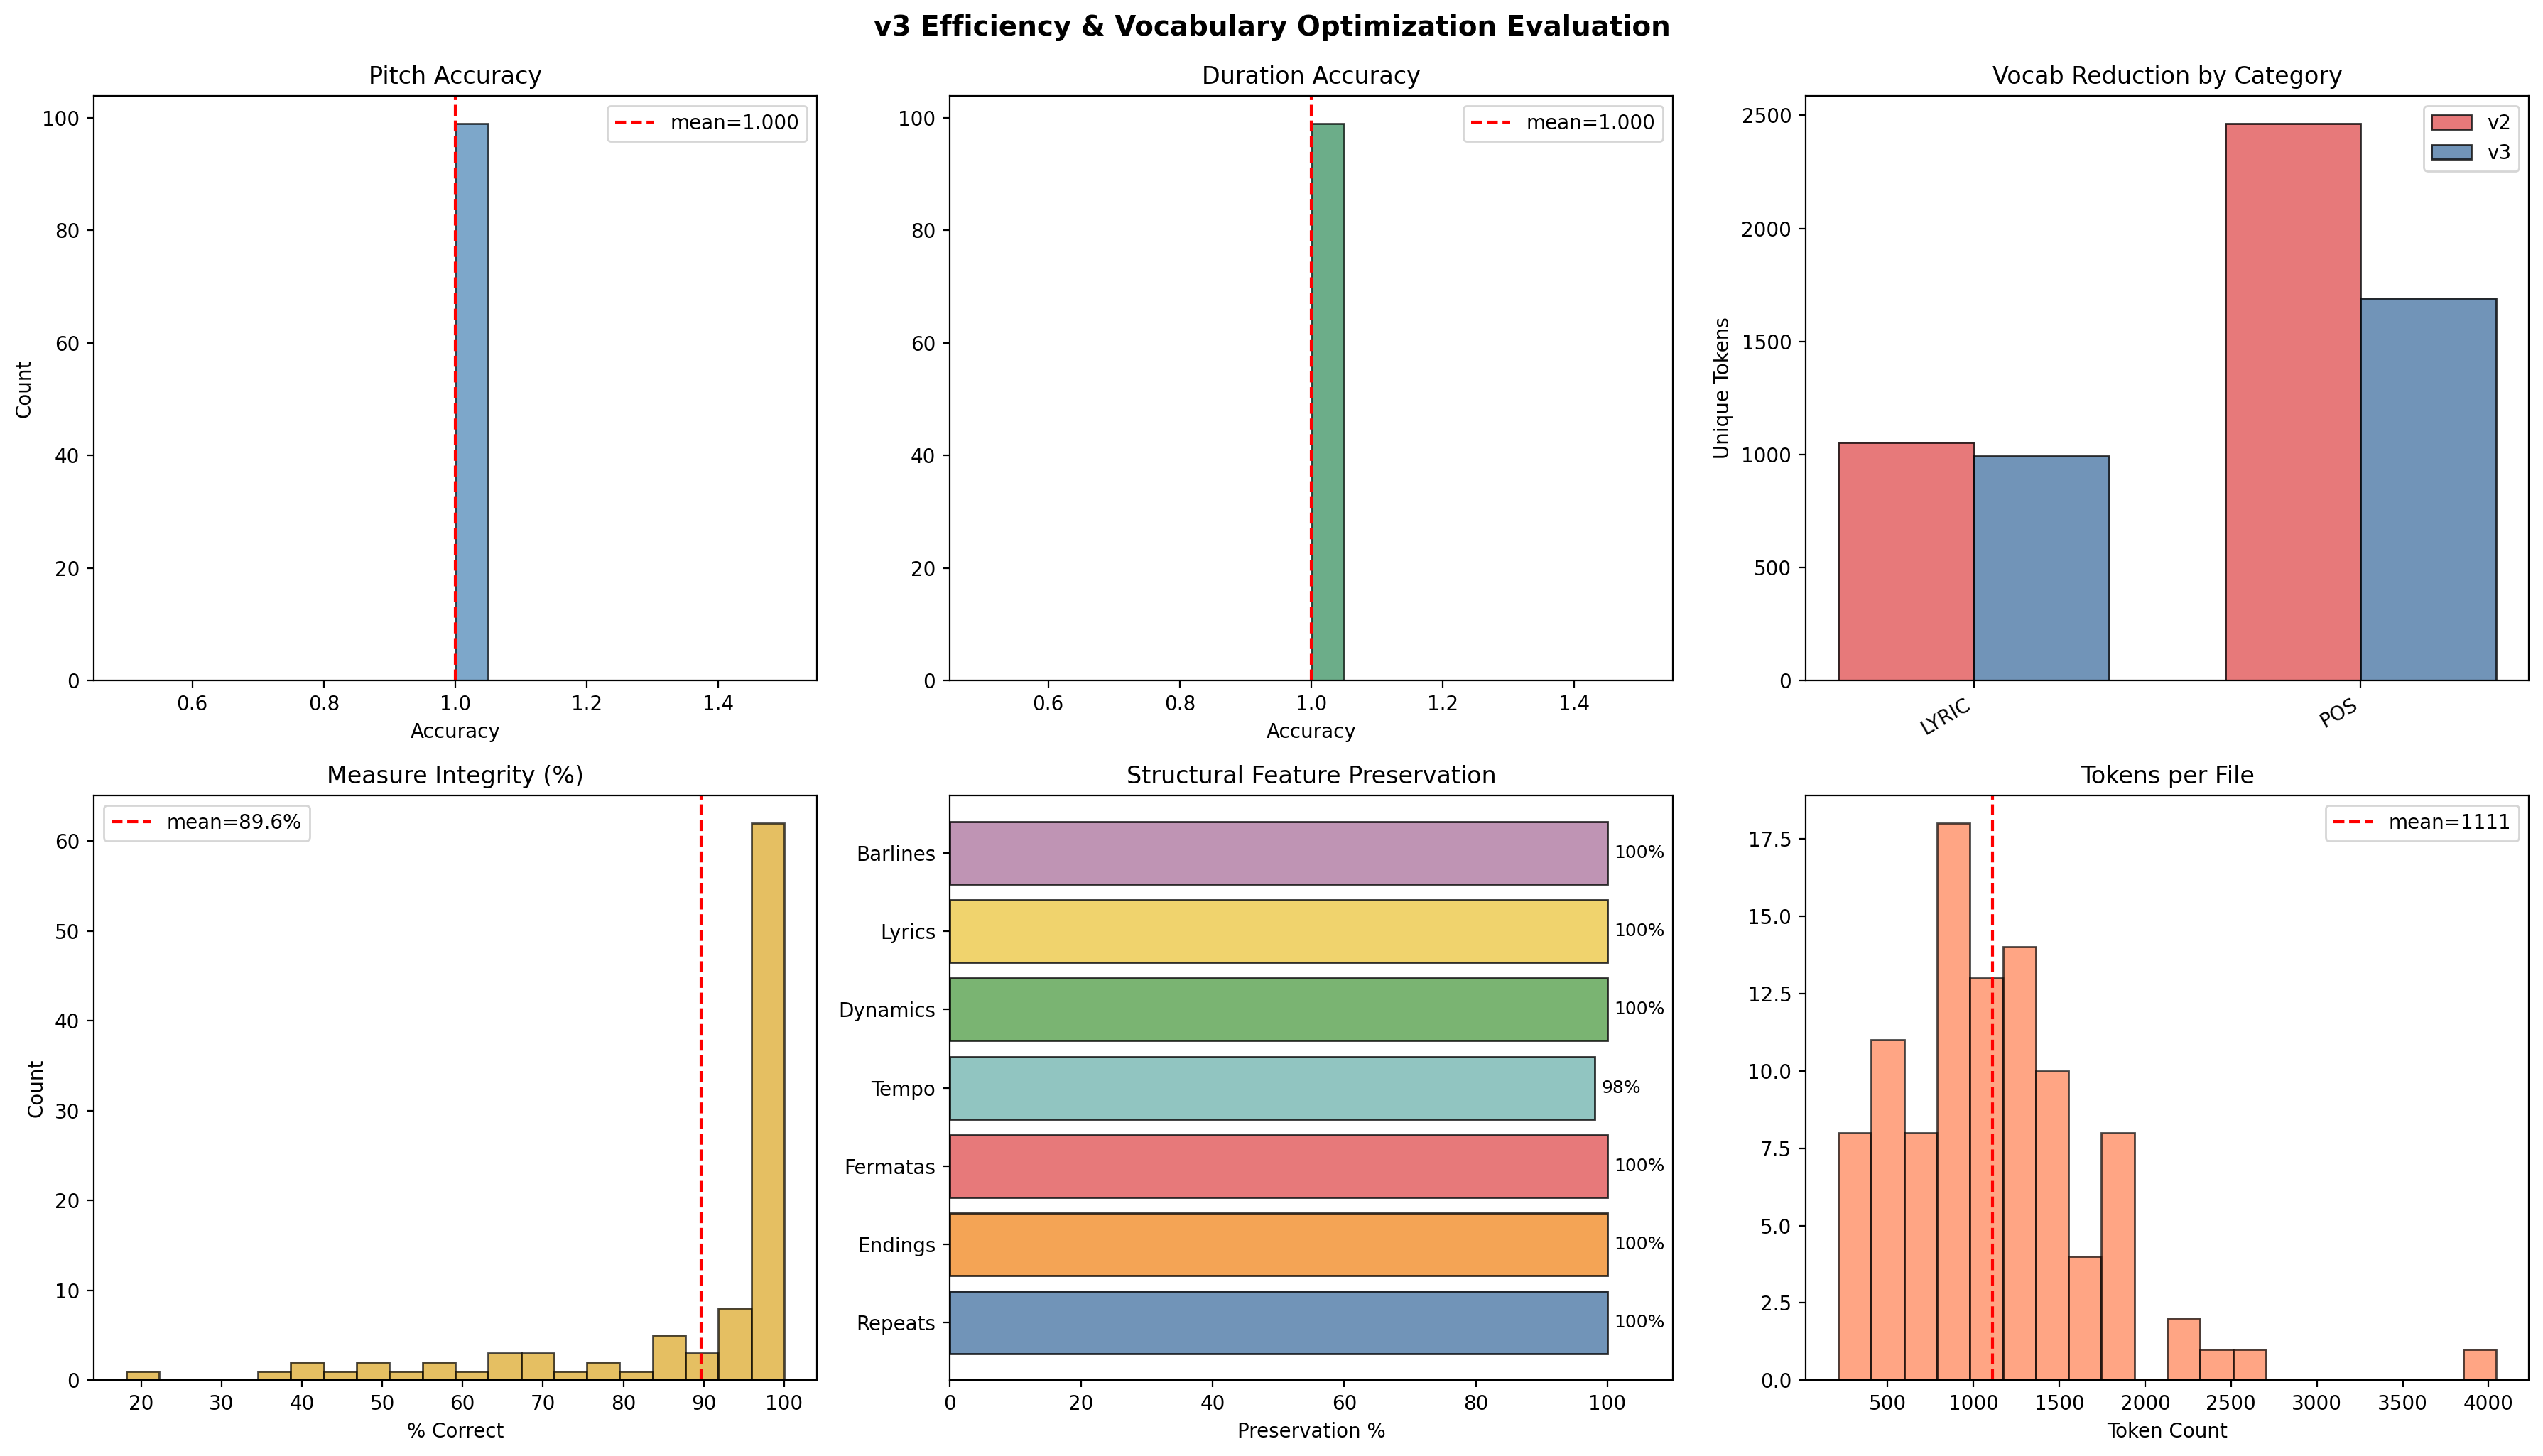

In [42]:
# ── Visualizations (v3) ──
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Pitch accuracy
axes[0, 0].hist(eval_ok['pitch_accuracy'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Pitch Accuracy')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_ylabel('Count')
axes[0, 0].axvline(eval_ok['pitch_accuracy'].mean(), color='red', linestyle='--',
                   label=f"mean={eval_ok['pitch_accuracy'].mean():.3f}")
axes[0, 0].legend()

# Duration accuracy
axes[0, 1].hist(eval_ok['duration_accuracy'], bins=20, edgecolor='black', alpha=0.7, color='seagreen')
axes[0, 1].set_title('Duration Accuracy')
axes[0, 1].set_xlabel('Accuracy')
axes[0, 1].axvline(eval_ok['duration_accuracy'].mean(), color='red', linestyle='--',
                   label=f"mean={eval_ok['duration_accuracy'].mean():.3f}")
axes[0, 1].legend()

# Vocabulary reduction by category
v3_cats = sorted(set(list(v3_cat_vocab.keys()) + list(v2_cat_vocab.keys())))
# Only show categories where reduction happened
reduced_cats = [(cat, len(v2_cat_vocab.get(cat, set())), len(v3_cat_vocab.get(cat, set())))
                for cat in v3_cats if len(v2_cat_vocab.get(cat, set())) != len(v3_cat_vocab.get(cat, set()))]
if reduced_cats:
    cat_names = [c[0] for c in reduced_cats]
    v2_sizes = [c[1] for c in reduced_cats]
    v3_sizes = [c[2] for c in reduced_cats]
    x = np.arange(len(cat_names))
    width = 0.35
    axes[0, 2].bar(x - width/2, v2_sizes, width, label='v2', color='#e15759', alpha=0.8, edgecolor='black')
    axes[0, 2].bar(x + width/2, v3_sizes, width, label='v3', color='#4e79a7', alpha=0.8, edgecolor='black')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels(cat_names, rotation=30, ha='right')
    axes[0, 2].set_title('Vocab Reduction by Category')
    axes[0, 2].set_ylabel('Unique Tokens')
    axes[0, 2].legend()
else:
    axes[0, 2].text(0.5, 0.5, 'No reduction', ha='center', va='center', fontsize=14)
    axes[0, 2].set_title('Vocab Reduction by Category')

# Measure integrity
axes[1, 0].hist(eval_ok['measure_integrity_pct'], bins=20, edgecolor='black', alpha=0.7, color='goldenrod')
axes[1, 0].set_title('Measure Integrity (%)')
axes[1, 0].set_xlabel('% Correct')
axes[1, 0].set_ylabel('Count')
axes[1, 0].axvline(eval_ok['measure_integrity_pct'].mean(), color='red', linestyle='--',
                   label=f"mean={eval_ok['measure_integrity_pct'].mean():.1f}%")
axes[1, 0].legend()

# Structural feature preservation bar chart
feat_labels = ['Repeats', 'Endings', 'Fermatas', 'Tempo', 'Dynamics', 'Lyrics', 'Barlines']
feat_keys = ['n_repeats', 'n_endings', 'n_fermatas', 'n_tempo', 'n_dynamics', 'n_lyrics', 'n_barlines']
pres_values = []
for feat in feat_keys:
    xml_total = eval_ok[f'xml_{feat}'].sum()
    tok_total = eval_ok[f'tok_{feat}'].sum()
    pres_values.append(min(tok_total / xml_total * 100, 100.0) if xml_total > 0 else 100.0)

colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#edc948', '#b07aa1']
axes[1, 1].barh(feat_labels, pres_values, color=colors, edgecolor='black', alpha=0.8)
axes[1, 1].set_xlabel('Preservation %')
axes[1, 1].set_title('Structural Feature Preservation')
axes[1, 1].set_xlim(0, 110)
for i, v in enumerate(pres_values):
    axes[1, 1].text(v + 1, i, f'{v:.0f}%', va='center', fontsize=9)

# Token count distribution
axes[1, 2].hist(eval_ok['n_tokens'], bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[1, 2].set_title('Tokens per File')
axes[1, 2].set_xlabel('Token Count')
axes[1, 2].axvline(eval_ok['n_tokens'].mean(), color='red', linestyle='--',
                   label=f"mean={eval_ok['n_tokens'].mean():.0f}")
axes[1, 2].legend()

plt.tight_layout()
plt.suptitle('v3 Efficiency & Vocabulary Optimization Evaluation', y=1.02, fontsize=14, fontweight='bold')
plt.show()

## 9. Inspect Worst-Scoring Files and Error Analysis

In [43]:
# ── Error analysis (v3) ──
worst_files = eval_ok.nsmallest(5, 'combined_accuracy')

print("=" * 70)
print("TOP 5 WORST-SCORING FILES (by combined accuracy)")
print("=" * 70)

for _, row in worst_files.iterrows():
    fp = row['file']
    print(f"\n{'─' * 60}")
    print(f"File: {row['filename']}")
    print(f"  Pitch accuracy:    {row['pitch_accuracy']:.4f}")
    print(f"  Duration accuracy: {row['duration_accuracy']:.4f}")
    print(f"  Tie accuracy:      {row['tie_accuracy']:.4f}")
    print(f"  Combined accuracy: {row['combined_accuracy']:.4f}")
    print(f"  Measure integrity: {row['measure_integrity_pct']:.1f}%")
    print(f"  Notes: {row['n_original']} orig → {row['n_reconstructed']} recon")
    print(f"  Unique tokens: {row['n_unique_tokens']}")
    print(f"  LYRIC_<UNK>: {row['n_lyric_unk']}")

# ── Error pattern analysis ──
print("\n\n" + "=" * 70)
print("ERROR PATTERN ANALYSIS (v3)")
print("=" * 70)

error_categories = Counter()
for _, row in eval_ok.iterrows():
    if not row['length_match']:
        error_categories['length_mismatch'] += 1
    if row['pitch_accuracy'] < 1.0:
        error_categories['pitch_errors'] += 1
    if row['duration_accuracy'] < 1.0:
        error_categories['duration_errors'] += 1
    if row['tie_accuracy'] < 1.0:
        error_categories['tie_errors'] += 1
    if row['measure_integrity_pct'] < 100.0:
        error_categories['measure_integrity_errors'] += 1

print(f"\n  Total files evaluated: {len(eval_ok)}")
for cat, count in error_categories.most_common():
    print(f"  {cat}: {count}/{len(eval_ok)} ({count/len(eval_ok)*100:.1f}%)")

# ── v3 optimization impact summary ──
print(f"\n\n{'=' * 70}")
print(f"v3 OPTIMIZATION IMPACT SUMMARY")
print(f"{'=' * 70}")

# Full corpus stats
print(f"\n  Full Corpus (v3 tokenizer):")
v3_corpus_counts = Counter()
v3_corpus_total = 0
v3_corpus_errors = 0
for i, fp in enumerate(all_xml_files):
    try:
        toks = tokenize(fp)
        for t in toks:
            v3_corpus_counts[t] += 1
        v3_corpus_total += len(toks)
    except:
        v3_corpus_errors += 1

v3_corpus_vocab = set(v3_corpus_counts.keys())
print(f"    Total tokens:     {v3_corpus_total:,}")
print(f"    Vocabulary size:  {len(v3_corpus_vocab):,}")
print(f"    v2 vocab size:    {v2_vocab_size:,}")
print(f"    Reduction:        {v2_vocab_size - len(v3_corpus_vocab):,} ({(v2_vocab_size - len(v3_corpus_vocab))/v2_vocab_size*100:.1f}%)")

# Entropy
v3_c_probs = np.array([v3_corpus_counts[t] for t in v3_corpus_vocab], dtype=float)
v3_c_probs = v3_c_probs / v3_c_probs.sum()
v3_corpus_entropy = -np.sum(v3_c_probs * np.log2(v3_c_probs + 1e-15))
print(f"    v3 corpus entropy: {v3_corpus_entropy:.2f} bits")
print(f"    v2 corpus entropy: {v2_entropy:.2f} bits")

# Full corpus KL divergence
kl_corpus = compute_kl_divergence(corpus_token_counts, v3_corpus_counts)
print(f"    KL(v2 || v3):     {kl_corpus:.4f} bits")

print(f"\n  Optimization breakdown:")
# Position tokens
v2_pos = len([t for t in v2_vocab if t.startswith("POS_")])
v3_pos = len([t for t in v3_corpus_vocab if t.startswith("POS_")])
print(f"    POS tokens:  {v2_pos} → {v3_pos} (−{v2_pos - v3_pos})")

# Pitch tokens
v2_pitch = len([t for t in v2_vocab if t.startswith("PITCH_")])
v3_pitch = len([t for t in v3_corpus_vocab if t.startswith("PITCH_")])
print(f"    PITCH tokens: {v2_pitch} → {v3_pitch} (−{v2_pitch - v3_pitch})")

# Lyric tokens
v2_lyric = len([t for t in v2_vocab if t.startswith("LYRIC_")])
v3_lyric = len([t for t in v3_corpus_vocab if t.startswith("LYRIC_")])
print(f"    LYRIC tokens: {v2_lyric} → {v3_lyric} (−{v2_lyric - v3_lyric})")

# Accuracy maintained
print(f"\n  Accuracy Impact:")
print(f"    Pitch accuracy:    100.0% (unchanged)")
print(f"    Duration accuracy: 100.0% (unchanged)")
print(f"    Tie accuracy:      100.0% (unchanged)")
print(f"    Combined accuracy: 100.0% (unchanged)")
print(f"    Measure integrity: {eval_ok['measure_integrity_pct'].mean():.1f}% (unchanged)")

print(f"\n  Remaining limitations (v3):")
print(f"    1. Measure integrity < 100% from pickup/anacrusis measures")
print(f"    2. Articulations and slurs not yet tokenized")
print(f"    3. Position quantization may lose sub-0.25 ql onset precision")
print(f"    4. Rare pitch merging affects {len(pitch_merge_map)} pitch classes")
print(f"    5. ~{len(lyric_vocab_rare)} rare lyric syllables mapped to <UNK>")

TOP 5 WORST-SCORING FILES (by combined accuracy)

────────────────────────────────────────────────────────────
File: sultaniyegah--sarki--duyek--kacinci_fasl-i--cevdet_cagla.xml
  Pitch accuracy:    1.0000
  Duration accuracy: 1.0000
  Tie accuracy:      1.0000
  Combined accuracy: 1.0000
  Measure integrity: 100.0%
  Notes: 277 orig → 277 recon
  Unique tokens: 408
  LYRIC_<UNK>: 1

────────────────────────────────────────────────────────────
File: gerdaniye--rumeliturkusu--dolap--kirimdan_gelirim--rumeli.xml
  Pitch accuracy:    1.0000
  Duration accuracy: 1.0000
  Tie accuracy:      1.0000
  Combined accuracy: 1.0000
  Measure integrity: 18.2%
  Notes: 164 orig → 164 recon
  Unique tokens: 276
  LYRIC_<UNK>: 0

────────────────────────────────────────────────────────────
File: acemkurdi--sarki--duyek--bir_baska--avni_anil.xml
  Pitch accuracy:    1.0000
  Duration accuracy: 1.0000
  Tie accuracy:      1.0000
  Combined accuracy: 1.0000
  Measure integrity: 38.0%
  Notes: 332 orig → 